<a href="https://colab.research.google.com/github/ykitaguchi77/CorneAI/blob/main/YOLOv5_CutMix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**YOLOv5_CutMix**

In [1]:
import os
import pandas as pd

# prompt: gdriveをマウント
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
folder_path = '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_CutMix/CutMix_images/Cutmix_mixed_img'
os.listdir(folder_path)


['back_normal',
 'back_infection',
 'back_tumor',
 'back_deposit',
 'back_scar',
 'back_non-infection',
 'back_apac',
 'back_lens-opacity',
 'back_bullous']

#**Underbar to Hyphen**

lens_opacity --> lens-opacity

In [ ]:
import os

def rename_item(old_path):
    directory, item_name = os.path.split(old_path)
    new_name = item_name
    if "lens_opacity" in item_name:
        new_name = new_name.replace("lens_opacity", "lens-opacity")
    if "non_infection" in item_name:
        new_name = new_name.replace("non_infection", "non-infection")

    if new_name != item_name:
        new_path = os.path.join(directory, new_name)
        os.rename(old_path, new_path)
        print(f"Renamed: {item_name} -> {new_name}")
        return new_path
    return old_path

def rename_files_and_directories(folder_path):
    for root, dirs, files in os.walk(folder_path, topdown=False):
        # まずファイルの名前を変更
        for file in files:
            old_path = os.path.join(root, file)
            rename_item(old_path)

        # 次にディレクトリの名前を変更
        for dir in dirs:
            old_path = os.path.join(root, dir)
            new_path = rename_item(old_path)

            # ディレクトリ名が変更された場合、親ディレクトリのパスも更新
            if new_path != old_path:
                index = dirs.index(dir)
                dirs[index] = os.path.basename(new_path)

# 使用例
folder_path = "/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_CutMix/CutMix_images/Cutmix_mixed_img"  # ここに実際のフォルダパスを指定してください
folder_path = "/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_CutMix/CutMix_images/cornea"
rename_files_and_directories(folder_path)

#**inference YOLOv5**

In [ ]:
%cd /content
!pip uninstall deep_utils -y
!pip install -U git+https://github.com/pooya-mohammadi/deep_utils.git --q
!pip install torch --q
!pip install torchvision --q
!pip install -U opencv-python --q
print("[INFO] To use new installed version of opencv, the session should be restarted!!!!")

!git clone https://github.com/pooya-mohammadi/yolov5-gradcam

/content
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 61.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 10.0 MB/s eta 0:00:00
[INFO] To use new installed version of opencv, the session should be restarted!!!!
Cloning into 'yolov5-gradcam'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 134 (delta 29), reused 36 (delta 13), pack-reused 68
Receiving objects: 100% (134/134), 6.95 MiB | 26.44 MiB/s, done.
Resolving deltas: 100% (49/49), done.


In [ ]:
import gc
gc.collect()

41

In [ ]:
os.chdir('/content/yolov5-gradcam')

In [ ]:
#################
#################

import numpy as np
from deep_utils.utils.box_utils.boxes import Box
import torch
from models.experimental import attempt_load
from utils.general import xywh2xyxy
from utils.datasets import letterbox
import cv2
import time
import torchvision
import torch.nn as nn
from utils.metrics import box_iou

class YOLOV5TorchObjectDetector(nn.Module):
    def __init__(self,
                 model_weight,
                 device,
                 img_size,
                 names=None,
                 mode='eval',
                 confidence=0.25,
                 iou_thresh=0.45,
                 agnostic_nms=False):
        super(YOLOV5TorchObjectDetector, self).__init__()
        self.device = device
        self.model = None
        self.img_size = img_size
        self.mode = mode
        self.confidence = confidence
        self.iou_thresh = iou_thresh
        self.agnostic = agnostic_nms
        self.model = attempt_load(model_weight, device=device)
        print("[INFO] Model is loaded")
        self.model.requires_grad_(True)
        self.model.to(device)
        if self.mode == 'train':
            self.model.train()
        else:
            self.model.eval()
        # fetch the names
        if names is None:
            print('[INFO] fetching names from coco file')
            self.names = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat',
                          'traffic light',
                          'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep',
                          'cow',
                          'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase',
                          'frisbee',
                          'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard',
                          'surfboard',
                          'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana',
                          'apple',
                          'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair',
                          'couch',
                          'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
                          'keyboard', 'cell phone',
                          'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
                          'teddy bear',
                          'hair drier', 'toothbrush']
        else:
            self.names = names

        # preventing cold start
        img = torch.zeros((1, 3, *self.img_size), device=device)
        self.model(img)

    @staticmethod
    def non_max_suppression(prediction, logits, conf_thres=0.25, iou_thres=0.45, classes=None, agnostic=False,
                            multi_label=False, labels=(), max_det=300):
        """Runs Non-Maximum Suppression (NMS) on inference and logits results

        Returns:
             list of detections, on (n,6) tensor per image [xyxy, conf, cls] and pruned input logits (n, number-classes)
        """

        nc = prediction.shape[2] - 5  # number of classes
        xc = prediction[..., 4] > conf_thres  # candidates

        # Checks
        assert 0 <= conf_thres <= 1, f'Invalid Confidence threshold {conf_thres}, valid values are between 0.0 and 1.0'
        assert 0 <= iou_thres <= 1, f'Invalid IoU {iou_thres}, valid values are between 0.0 and 1.0'

        # Settings
        min_wh, max_wh = 2, 4096  # (pixels) minimum and maximum box width and height
        max_nms = 30000  # maximum number of boxes into torchvision.ops.nms()
        time_limit = 10.0  # seconds to quit after
        redundant = True  # require redundant detections
        multi_label &= nc > 1  # multiple labels per box (adds 0.5ms/img)
        merge = False  # use merge-NMS

        t = time.time()
        output = [torch.zeros((0, 6), device=prediction.device)] * prediction.shape[0]
        logits_output = [torch.zeros((0, 80), device=logits.device)] * logits.shape[0]
        for xi, (x, log_) in enumerate(zip(prediction, logits)):  # image index, image inference
            # Apply constraints
            # x[((x[..., 2:4] < min_wh) | (x[..., 2:4] > max_wh)).any(1), 4] = 0  # width-height
            x = x[xc[xi]]  # confidence
            log_ = log_[xc[xi]]
            # Cat apriori labels if autolabelling
            if labels and len(labels[xi]):
                l = labels[xi]
                v = torch.zeros((len(l), nc + 5), device=x.device)
                v[:, :4] = l[:, 1:5]  # box
                v[:, 4] = 1.0  # conf
                v[range(len(l)), l[:, 0].long() + 5] = 1.0  # cls
                x = torch.cat((x, v), 0)

            # If none remain process next image
            if not x.shape[0]:
                continue

            # Compute conf
            x[:, 5:] *= x[:, 4:5]  # conf = obj_conf * cls_conf
            # log_ *= x[:, 4:5]
            # Box (center x, center y, width, height) to (x1, y1, x2, y2)
            box = xywh2xyxy(x[:, :4])

            # Detections matrix nx6 (xyxy, conf, cls)
            if multi_label:
                i, j = (x[:, 5:] > conf_thres).nonzero(as_tuple=False).T
                x = torch.cat((box[i], x[i, j + 5, None], j[:, None].float()), 1)
            else:  # best class only
                conf, j = x[:, 5:].max(1, keepdim=True)
                # log_ = x[:, 5:]
                x = torch.cat((box, conf, j.float()), 1)[conf.view(-1) > conf_thres]
                log_ = log_[conf.view(-1) > conf_thres]
            # Filter by class
            if classes is not None:
                x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]

            # Check shape
            n = x.shape[0]  # number of boxes
            if not n:  # no boxes
                continue
            elif n > max_nms:  # excess boxes
                x = x[x[:, 4].argsort(descending=True)[:max_nms]]  # sort by confidence

            # Batched NMS
            c = x[:, 5:6] * (0 if agnostic else max_wh)  # classes
            boxes, scores = x[:, :4] + c, x[:, 4]  # boxes (offset by class), scores
            i = torchvision.ops.nms(boxes, scores, iou_thres)  # NMS
            if i.shape[0] > max_det:  # limit detections
                i = i[:max_det]
            if merge and (1 < n < 3E3):  # Merge NMS (boxes merged using weighted mean)
                # update boxes as boxes(i,4) = weights(i,n) * boxes(n,4)
                iou = box_iou(boxes[i], boxes) > iou_thres  # iou matrix
                weights = iou * scores[None]  # box weights
                x[i, :4] = torch.mm(weights, x[:, :4]).float() / weights.sum(1, keepdim=True)  # merged boxes
                if redundant:
                    i = i[iou.sum(1) > 1]  # require redundancy

            output[xi] = x[i]
            logits_output[xi] = log_[i]
            assert log_[i].shape[0] == x[i].shape[0]
            if (time.time() - t) > time_limit:
                print(f'WARNING: NMS time limit {time_limit}s exceeded')
                break  # time limit exceeded

        return output, logits_output

    @staticmethod
    def yolo_resize(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):

        return letterbox(img, new_shape=new_shape, color=color, auto=auto, scaleFill=scaleFill, scaleup=scaleup)

    def forward(self, img):
        prediction, logits, _ = self.model(img, augment=False)
        prediction, logits = self.non_max_suppression(prediction, logits, self.confidence, self.iou_thresh,
                                                      classes=None,
                                                      agnostic=self.agnostic)
        self.boxes, self.class_names, self.classes, self.confidences = [[[] for _ in range(img.shape[0])] for _ in
                                                                        range(4)]
        for i, det in enumerate(prediction):  # detections per image
            if len(det):
                for *xyxy, conf, cls in det:
                    # xyxyの値を修正
                    xyxy[0] = max(0, xyxy[0])
                    xyxy[1] = max(0, xyxy[1])
                    xyxy[2] = min(img_size, xyxy[2])
                    xyxy[3] = min(img_size, xyxy[3])

                    bbox = Box.box2box(xyxy,
                                       in_source=Box.BoxSource.Torch,
                                       to_source=Box.BoxSource.Numpy,
                                       return_int=True)
                    self.boxes[i].append(bbox)
                    self.confidences[i].append(round(conf.item(), 2))
                    cls = int(cls.item())
                    self.classes[i].append(cls)
                    if self.names is not None:
                        self.class_names[i].append(self.names[cls])
                    else:
                        self.class_names[i].append(cls)
        return [self.boxes, self.classes, self.class_names, self.confidences], logits

    def preprocessing(self, img):
        if len(img.shape) != 4:
            img = np.expand_dims(img, axis=0)
        im0 = img.astype(np.uint8)
        img = np.array([self.yolo_resize(im, new_shape=self.img_size)[0] for im in im0])
        img = img.transpose((0, 3, 1, 2))
        img = np.ascontiguousarray(img)
        img = torch.from_numpy(img).to(self.device)
        img = img / 255.0
        return img


import os
import time
import numpy as np
# from models.gradcam import YOLOV5GradCAM
#from models.yolo_v5_object_detector import YOLOV5TorchObjectDetector
import cv2
from google.colab.patches import cv2_imshow
from deep_utils import Box, split_extension
import gc

import torch
import torch.nn.functional as F

# クラス名リストを指定
names = ["infection","normal","non-infection","scar","tumor","deposit","APAC","lens opacity","bullous"]

# 以下の関数は変更なし
def get_res_img(bbox, masks, res_img):
    for mask in masks:
        mask = mask.squeeze().mul(255).add_(0.5).clamp_(0, 255).detach().cpu().numpy().astype(np.uint8)
        heatmap = cv2.applyColorMap(mask, cv2.COLORMAP_JET)
        n_heatmat = (Box.fill_outer_box(heatmap, bbox) / 255).astype(np.float32)
        res_img = res_img / 255
        res_img = cv2.add(res_img, n_heatmat)
        res_img = (res_img / res_img.max())
    return res_img, n_heatmat

def put_text_box(bbox, cls_name, res_img):
    x1, y1, x2, y2 = bbox
    cv2.imwrite('temp.jpg', (res_img * 255).astype(np.uint8))
    res_img = cv2.imread('temp.jpg')
    res_img = Box.put_box(res_img, bbox)

    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 2.0
    color = (0, 255, 0)  # Green color in BGR format
    thickness = 2

    text_size, _ = cv2.getTextSize(cls_name, font, font_scale, thickness)
    text_x = 10
    text_y = text_size[1] + 10

    cv2.putText(res_img, cls_name, (text_x, text_y), font, font_scale, color, thickness)

    return res_img

def concat_images(images):
    w, h = images[0].shape[:2]
    width = w
    height = h * len(images)
    base_img = np.zeros((width, height, 3), dtype=np.uint8)
    for i, img in enumerate(images):
        base_img[:, h * i:h * (i + 1), ...] = img
    return base_img

def find_yolo_layer(model, layer_name):
    hierarchy = layer_name.split('_')
    target_layer = model.model._modules[hierarchy[0]]

    for h in hierarchy[1:]:
        target_layer = target_layer._modules[h]
    return target_layer

# YOLOV5GradCAMクラスを更新
class YOLOV5GradCAM:
    def __init__(self, model, layer_name, img_size=(640, 640), method='gradcam'):
        self.model = model
        self.gradients = dict()
        self.activations = dict()
        self.method = method
        self.cls_names = []  # クラス名を格納するリストを初期化

        def backward_hook(module, grad_input, grad_output):
            self.gradients['value'] = grad_output[0]
            return None

        def forward_hook(module, input, output):
            self.activations['value'] = output
            return None

        target_layer = find_yolo_layer(self.model, layer_name)
        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)

        device = 'cuda' if next(self.model.model.parameters()).is_cuda else 'cpu'
        self.model(torch.zeros(1, 3, *img_size, device=device))


    def forward(self, input_img, class_idx=True):
        saliency_maps = []
        b, c, h, w = input_img.size()
        preds, logits = self.model(input_img)

        _, top3_indices = torch.topk(logits[0], k=3)

        if top3_indices.numel() > 0:
            preds[1][0] = top3_indices.tolist()[0]
            preds[2][0] = [names[i] for i in preds[1][0]]
            self.cls_names = preds[2][0]
        else:
            self.cls_names = []

        if self.method == 'eigencam':
            saliency_map = self._eigencam()
            saliency_maps.append(saliency_map)
        else:
            for cls, cls_name in zip(preds[1][0], preds[2][0]):
                if class_idx:
                    score = logits[0][0][cls]
                else:
                    score = logits[0][0].max()
                self.model.zero_grad()
                score.backward(retain_graph=True)
                gradients = self.gradients['value']
                activations = self.activations['value']
                b, k, u, v = gradients.size()

                if self.method == 'gradcam':
                    weights = self._gradcam_weights(gradients, b, k)
                elif self.method == 'gradcampp':
                    weights = self._gradcampp_weights(gradients, activations, score, b, k, u, v)

                saliency_map = (weights * activations).sum(1, keepdim=True)
                saliency_map = F.relu(saliency_map)
                saliency_map = F.interpolate(saliency_map, size=(h, w), mode='bilinear', align_corners=False)
                saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
                saliency_map = (saliency_map - saliency_map_min).div(saliency_map_max - saliency_map_min).data
                saliency_maps.append(saliency_map)

        return saliency_maps, logits, preds, self.cls_names

    def _gradcam_weights(self, gradients, b, k):
        alpha = gradients.view(b, k, -1).mean(2)
        return alpha.view(b, k, 1, 1)

    def _gradcampp_weights(self, gradients, activations, score, b, k, u, v):
        alpha_num = gradients.pow(2)
        alpha_denom = gradients.pow(2).mul(2) + \
            activations.mul(gradients.pow(3)).view(b, k, u*v).sum(-1, keepdim=True).view(b, k, 1, 1)
        alpha_denom = torch.where(alpha_denom != 0.0, alpha_denom, torch.ones_like(alpha_denom))
        alpha = alpha_num.div(alpha_denom + 1e-7)
        positive_gradients = F.relu(score.exp() * gradients)
        weights = (positive_gradients * alpha).view(b, k, u*v).sum(-1).view(b, k, 1, 1)
        return weights

    def _eigencam(self):
        activations = self.activations['value']
        b, k, u, v = activations.size()
        activations_reshaped = activations.view(b, k, -1)

        # Compute covariance matrix
        cov = activations_reshaped @ activations_reshaped.transpose(-1, -2)
        cov /= (u * v)

        # Compute eigenvectors
        eigenvalues, eigenvectors = torch.linalg.eigh(cov)

        # Select the eigenvector corresponding to the largest eigenvalue
        leading_eigenvector = eigenvectors[..., -1].unsqueeze(-1)

        # Compute EigenCAM
        eigen_cam = (activations_reshaped.transpose(-1, -2) @ leading_eigenvector).view(b, u, v)
        eigen_cam = F.relu(eigen_cam)

        # Normalize
        eigen_cam_min, eigen_cam_max = eigen_cam.min(), eigen_cam.max()
        eigen_cam = (eigen_cam - eigen_cam_min) / (eigen_cam_max - eigen_cam_min + 1e-8)

        return eigen_cam.unsqueeze(1)

    def __call__(self, input_img):
        return self.forward(input_img)


import os
import torch
import cv2
import numpy as np
import time
import torchvision
from utils.general import xywh2xyxy
from utils.datasets import letterbox
from utils.metrics import box_iou
from models.experimental import attempt_load
from deep_utils.utils.box_utils.boxes import Box
import torch.nn as nn

class YOLOV5TorchObjectDetector(nn.Module):
    def __init__(self,
                 model_weight,
                 device,
                 img_size,
                 names=None,
                 mode='eval',
                 confidence=0.25,
                 iou_thresh=0.45,
                 agnostic_nms=False):
        super(YOLOV5TorchObjectDetector, self).__init__()
        self.device = device
        self.img_size = img_size
        self.mode = mode
        self.confidence = confidence
        self.iou_thresh = iou_thresh
        self.agnostic = agnostic_nms
        self.model = attempt_load(model_weight, device=device)
        print("[INFO] Model is loaded")
        self.model.requires_grad_(True)
        self.model.to(device)
        if self.mode == 'train':
            self.model.train()
        else:
            self.model.eval()
        self.names = names if names else self.model.names

        # Prevent cold start
        img = torch.zeros((1, 3, *self.img_size), device=device)
        self.model(img)

    @staticmethod
    def non_max_suppression(prediction, logits, conf_thres=0.25, iou_thres=0.45, classes=None, agnostic=False,
                            multi_label=False, labels=(), max_det=300):
        nc = prediction.shape[2] - 5  # number of classes
        xc = prediction[..., 4] > conf_thres  # candidates

        # Settings
        min_wh, max_wh = 2, 4096  # (pixels) minimum and maximum box width and height
        max_nms = 30000  # maximum number of boxes into torchvision.ops.nms()
        time_limit = 10.0  # seconds to quit after
        redundant = True  # require redundant detections
        multi_label &= nc > 1  # multiple labels per box (adds 0.5ms/img)
        merge = False  # use merge-NMS

        t = time.time()
        output = [torch.zeros((0, 6), device=prediction.device)] * prediction.shape[0]
        logits_output = [torch.zeros((0, nc), device=logits.device)] * logits.shape[0]
        for xi, (x, log_) in enumerate(zip(prediction, logits)):  # image index, image inference
            x = x[xc[xi]]  # confidence
            log_ = log_[xc[xi]]

            # If none remain process next image
            if not x.shape[0]:
                continue

            # Compute conf
            x[:, 5:] *= x[:, 4:5]  # conf = obj_conf * cls_conf

            # Box (center x, center y, width, height) to (x1, y1, x2, y2)
            box = xywh2xyxy(x[:, :4])

            # Detections matrix nx6 (xyxy, conf, cls)
            if multi_label:
                i, j = (x[:, 5:] > conf_thres).nonzero(as_tuple=False).T
                x = torch.cat((box[i], x[i, j + 5, None], j[:, None].float()), 1)
            else:  # best class only
                conf, j = x[:, 5:].max(1, keepdim=True)
                x = torch.cat((box, conf, j.float()), 1)[conf.view(-1) > conf_thres]
                log_ = log_[conf.view(-1) > conf_thres]

            # Filter by class
            if classes is not None:
                x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]

            # Apply finite constraint
            # if not torch.isfinite(x).all():
            #     x = x[torch.isfinite(x).all(1)]

            # Check shape
            n = x.shape[0]  # number of boxes
            if not n:  # no boxes
                continue
            elif n > max_nms:  # excess boxes
                x = x[x[:, 4].argsort(descending=True)[:max_nms]]  # sort by confidence

            # Batched NMS
            c = x[:, 5:6] * (0 if agnostic else max_wh)  # classes
            boxes, scores = x[:, :4] + c, x[:, 4]  # boxes (offset by class), scores
            i = torchvision.ops.nms(boxes, scores, iou_thres)  # NMS
            if i.shape[0] > max_det:  # limit detections
                i = i[:max_det]
            if merge and (1 < n < 3E3):  # Merge NMS (boxes merged using weighted mean)
                # update boxes as boxes(i,4) = weights(i,n) * boxes(n,4)
                iou = box_iou(boxes[i], boxes) > iou_thres  # iou matrix
                weights = iou * scores[None]  # box weights
                x[i, :4] = torch.mm(weights, x[:, :4]).float() / weights.sum(1, keepdim=True)  # merged boxes
                if redundant:
                    i = i[iou.sum(1) > 1]  # require redundancy

            output[xi] = x[i]
            logits_output[xi] = log_[i]
            if (time.time() - t) > time_limit:
                print(f'WARNING: NMS time limit {time_limit}s exceeded')
                break  # time limit exceeded

        return output, logits_output

    @staticmethod
    def yolo_resize(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):
        return letterbox(img, new_shape=new_shape, color=color, auto=auto, scaleFill=scaleFill, scaleup=scaleup)

    def forward(self, img):
        prediction, logits, _ = self.model(img, augment=False)
        prediction, logits = self.non_max_suppression(prediction, logits, self.confidence, self.iou_thresh,
                                                      classes=None, agnostic=self.agnostic)
        self.boxes, self.class_names, self.classes, self.confidences = [[[] for _ in range(img.shape[0])] for _ in range(4)]
        for i, det in enumerate(prediction):  # detections per image
            if len(det):
                for *xyxy, conf, cls in det:
                    xyxy[0] = max(0, xyxy[0])
                    xyxy[1] = max(0, xyxy[1])
                    xyxy[2] = min(self.img_size[0], xyxy[2])
                    xyxy[3] = min(self.img_size[1], xyxy[3])

                    bbox = Box.box2box(xyxy,
                                       in_source=Box.BoxSource.Torch,
                                       to_source=Box.BoxSource.Numpy,
                                       return_int=True)
                    self.boxes[i].append(bbox)
                    self.confidences[i].append(round(conf.item(), 2))
                    cls = int(cls.item())
                    self.classes[i].append(cls)
                    self.class_names[i].append(self.names[cls])
        return [self.boxes, self.classes, self.class_names, self.confidences], logits

    def preprocessing(self, img):
        if len(img.shape) != 4:
            img = np.expand_dims(img, axis=0)
        im0 = img.astype(np.uint8)
        img = np.array([self.yolo_resize(im, new_shape=self.img_size)[0] for im in im0])
        img = img.transpose((0, 3, 1, 2))
        img = np.ascontiguousarray(img)
        img = torch.from_numpy(img).to(self.device)
        img = img / 255.0
        return img

def process_image(img_path, model):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    torch_img = model.preprocessing(img)

    with torch.no_grad():
        prediction, logits = model(torch_img)

    # Top 1 クラスとその確率を取得
    if len(prediction[2][0]) > 0:
        top_class = prediction[2][0][0]
        top_prob = prediction[3][0][0]
        return top_class, top_prob
    else:
        return "No detection", 0.0

#**YOLOv5_GradCAM**

In [ ]:
def main(img_path, method):
    input_size = (img_size, img_size)
    img = cv2.imread(img_path)
    model = YOLOV5TorchObjectDetector(model_path, device, img_size=input_size, names=names)
    torch_img = model.preprocessing(img[..., ::-1])

    saliency_method = YOLOV5GradCAM(model=model, layer_name=target_layer, img_size=input_size, method=method)

    tic = time.time()
    masks, logits, [boxes, _, _, _], cls_names = saliency_method(torch_img)
    print("total time:", round(time.time() - tic, 4))

    result = torch_img.squeeze(0).mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).detach().cpu().numpy()
    result = result[..., ::-1]  # convert to bgr
    images = [result]

    for i in range(len(masks)):
        res_img = result.copy()
        for j, mask in enumerate(masks[i]):
            bbox = boxes[0][j]
            res_img, _ = get_res_img(bbox, [mask], res_img)
            res_img = put_text_box(bbox, cls_names[i], res_img)
        images.append(res_img)

    final_image = concat_images(images)
    img_name = split_extension(os.path.split(img_path)[-1], suffix=f'-res-{method}')
    output_path = f'{output_dir}/{img_name}'
    os.makedirs(output_dir, exist_ok=True)
    print(f'[INFO] Saving the final image at {output_path}')
    cv2_imshow(final_image)

def folder_main(folder_path, method):
    input_size = (img_size, img_size)
    model = YOLOV5TorchObjectDetector(model_path, device, img_size=input_size, names=names)

    #####ファイル名を数字でソート################
    file_list = os.listdir(folder_path)
    #############################################

    for item in file_list:
        img_path = os.path.join(folder_path, item)
        img_basename = os.path.basename(img_path)
        print(f"Processing image: {img_basename}")
        img = cv2.imread(img_path)

        # 元の画像の縦横比を維持しながらリサイズ
        h, w = img.shape[:2]
        if h > w:
            new_h, new_w = img_size, int(img_size * w / h)
        else:
            new_h, new_w = int(img_size * h / w), img_size
        img = cv2.resize(img, (new_w, new_h))

        # パディングを追加して640×640pxにする
        delta_w = img_size - new_w
        delta_h = img_size - new_h
        top, bottom = delta_h // 2, delta_h - (delta_h // 2)
        left, right = delta_w // 2, delta_w - (delta_w // 2)
        img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

        torch_img = model.preprocessing(img[..., ::-1])

        saliency_method = YOLOV5GradCAM(model=model, layer_name=target_layer, img_size=input_size, method=method)

        masks, logits, [boxes, _, _, _], cls_names = saliency_method(torch_img)
        print(f"boxes: {boxes}")

        result = torch_img.squeeze(0).mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).detach().cpu().numpy()
        result = result[..., ::-1]  # convert to bgr
        images = [result]

        for i in range(len(masks)):
            res_img = result.copy()
            for j, mask in enumerate(masks[i]):
                bbox = boxes[0][j]
                res_img, _ = get_res_img(bbox, [mask], res_img)
                res_img = put_text_box(bbox, cls_names[i], res_img)
            images.append(res_img)

        final_image = concat_images(images)
        img_name = split_extension(os.path.split(img_path)[-1], suffix=f'-res-{method}')
        output_path = f'{output_dir}/{img_name}'
        os.makedirs(output_dir, exist_ok=True)
        print(f'[INFO] Saving the final image at {output_path}')

        cv2.imwrite(output_path, final_image)
        #cv2_imshow(final_image)

        # メモリ解放
        del saliency_method, masks, logits, boxes, images, final_image
        gc.collect()

if __name__ == '__main__':
    folder_path = '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_CutMix/CutMix_images/Cutmix_mixed_img'
    img_dir = os.path.join(folder_path, os.listdir(folder_path)[0])

    model_path = "/content/drive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"
    device = 'cpu'  # 'cuda' または 'cpu'
    img_size = 640  # 入力画像サイズ
    #target_layer = 'model_17_cv3_conv'  # GradCAM を適用するレイヤー
    #target_layer = 'model_20_cv3_conv'  # GradCAM を適用するレイヤー
    target_layer = 'model_23_cv3_conv'  # GradCAM を適用するレイヤー
    #target_layer = 'model_23_cv3_act'  # GradCAM を適用するレイヤー  →デフォルト
    #target_layer = 'model_23_m_0_cv2_conv'  # GradCAM を適用するレイヤー
    #target_layer = 'model_23_m_0_cv2_act'  # GradCAM を適用するレイヤー
    #target_layer = 'model_24_m_1'  # GradCAM を適用するレイヤー
    #target_layer = 'model_24_m_2'  # GradCAM を適用するレイヤー
    img_path = img_dir
    #output_dir = '/gdrive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_GradCAM/GradCam++_img_slit'  # 出力ディレクトリ
    output_dir = '/content/outputs'  # 出力ディレクトリ


    # GradCAMとGradCAM++の両方を実行
    #for method in ['gradcam', 'gradcampp', 'eigencam']:
    for method in ['gradcam', 'gradcampp']:
    #for method in ['gradcampp']:
        print(f"{method.upper()}を実行中:")
        if os.path.isdir(img_path):
            folder_main(img_path, method)
        else:
            main(img_path, method)


#**GradCAMなしバージョン**

In [ ]:
import os
import torch
import cv2
import numpy as np
import time
import torchvision
from utils.general import xywh2xyxy
from utils.datasets import letterbox
from utils.metrics import box_iou
from models.experimental import attempt_load
from deep_utils.utils.box_utils.boxes import Box
import torch.nn as nn

class YOLOV5TorchObjectDetector(nn.Module):
    def __init__(self,
                 model_weight,
                 device,
                 img_size,
                 names=None,
                 mode='eval',
                 confidence=0.25,
                 iou_thresh=0.45,
                 agnostic_nms=False):
        super(YOLOV5TorchObjectDetector, self).__init__()
        self.device = device
        self.img_size = img_size
        self.mode = mode
        self.confidence = confidence
        self.iou_thresh = iou_thresh
        self.agnostic = agnostic_nms
        self.model = attempt_load(model_weight, device=device)
        print("[INFO] Model is loaded")
        self.model.requires_grad_(True)
        self.model.to(device)
        if self.mode == 'train':
            self.model.train()
        else:
            self.model.eval()
        self.names = names if names else self.model.names

        # Prevent cold start
        img = torch.zeros((1, 3, *self.img_size), device=device)
        self.model(img)

    @staticmethod
    def non_max_suppression(prediction, logits, conf_thres=0.25, iou_thres=0.45, classes=None, agnostic=False,
                            multi_label=False, labels=(), max_det=300):
        nc = prediction.shape[2] - 5  # number of classes
        xc = prediction[..., 4] > conf_thres  # candidates

        # Settings
        min_wh, max_wh = 2, 4096  # (pixels) minimum and maximum box width and height
        max_nms = 30000  # maximum number of boxes into torchvision.ops.nms()
        time_limit = 10.0  # seconds to quit after
        redundant = True  # require redundant detections
        multi_label &= nc > 1  # multiple labels per box (adds 0.5ms/img)
        merge = False  # use merge-NMS

        t = time.time()
        output = [torch.zeros((0, 6), device=prediction.device)] * prediction.shape[0]
        logits_output = [torch.zeros((0, nc), device=logits.device)] * logits.shape[0]
        for xi, (x, log_) in enumerate(zip(prediction, logits)):  # image index, image inference
            x = x[xc[xi]]  # confidence
            log_ = log_[xc[xi]]

            # If none remain process next image
            if not x.shape[0]:
                continue

            # Compute conf
            x[:, 5:] *= x[:, 4:5]  # conf = obj_conf * cls_conf

            # Box (center x, center y, width, height) to (x1, y1, x2, y2)
            box = xywh2xyxy(x[:, :4])

            # Detections matrix nx6 (xyxy, conf, cls)
            if multi_label:
                i, j = (x[:, 5:] > conf_thres).nonzero(as_tuple=False).T
                x = torch.cat((box[i], x[i, j + 5, None], j[:, None].float()), 1)
            else:  # best class only
                conf, j = x[:, 5:].max(1, keepdim=True)
                x = torch.cat((box, conf, j.float()), 1)[conf.view(-1) > conf_thres]
                log_ = log_[conf.view(-1) > conf_thres]

            # Filter by class
            if classes is not None:
                x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]

            # Apply finite constraint
            # if not torch.isfinite(x).all():
            #     x = x[torch.isfinite(x).all(1)]

            # Check shape
            n = x.shape[0]  # number of boxes
            if not n:  # no boxes
                continue
            elif n > max_nms:  # excess boxes
                x = x[x[:, 4].argsort(descending=True)[:max_nms]]  # sort by confidence

            # Batched NMS
            c = x[:, 5:6] * (0 if agnostic else max_wh)  # classes
            boxes, scores = x[:, :4] + c, x[:, 4]  # boxes (offset by class), scores
            i = torchvision.ops.nms(boxes, scores, iou_thres)  # NMS
            if i.shape[0] > max_det:  # limit detections
                i = i[:max_det]
            if merge and (1 < n < 3E3):  # Merge NMS (boxes merged using weighted mean)
                # update boxes as boxes(i,4) = weights(i,n) * boxes(n,4)
                iou = box_iou(boxes[i], boxes) > iou_thres  # iou matrix
                weights = iou * scores[None]  # box weights
                x[i, :4] = torch.mm(weights, x[:, :4]).float() / weights.sum(1, keepdim=True)  # merged boxes
                if redundant:
                    i = i[iou.sum(1) > 1]  # require redundancy

            output[xi] = x[i]
            logits_output[xi] = log_[i]
            if (time.time() - t) > time_limit:
                print(f'WARNING: NMS time limit {time_limit}s exceeded')
                break  # time limit exceeded

        return output, logits_output

    @staticmethod
    def yolo_resize(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):
        return letterbox(img, new_shape=new_shape, color=color, auto=auto, scaleFill=scaleFill, scaleup=scaleup)

    def forward(self, img):
        prediction, logits, _ = self.model(img, augment=False)
        prediction, logits = self.non_max_suppression(prediction, logits, self.confidence, self.iou_thresh,
                                                      classes=None, agnostic=self.agnostic)
        self.boxes, self.class_names, self.classes, self.confidences = [[[] for _ in range(img.shape[0])] for _ in range(4)]
        for i, det in enumerate(prediction):  # detections per image
            if len(det):
                for *xyxy, conf, cls in det:
                    xyxy[0] = max(0, xyxy[0])
                    xyxy[1] = max(0, xyxy[1])
                    xyxy[2] = min(self.img_size[0], xyxy[2])
                    xyxy[3] = min(self.img_size[1], xyxy[3])

                    bbox = Box.box2box(xyxy,
                                       in_source=Box.BoxSource.Torch,
                                       to_source=Box.BoxSource.Numpy,
                                       return_int=True)
                    self.boxes[i].append(bbox)
                    self.confidences[i].append(round(conf.item(), 2))
                    cls = int(cls.item())
                    self.classes[i].append(cls)
                    self.class_names[i].append(self.names[cls])
        return [self.boxes, self.classes, self.class_names, self.confidences], logits

    def preprocessing(self, img):
        if len(img.shape) != 4:
            img = np.expand_dims(img, axis=0)
        im0 = img.astype(np.uint8)
        img = np.array([self.yolo_resize(im, new_shape=self.img_size)[0] for im in im0])
        img = img.transpose((0, 3, 1, 2))
        img = np.ascontiguousarray(img)
        img = torch.from_numpy(img).to(self.device)
        img = img / 255.0
        return img

def process_image(img_path, model):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    torch_img = model.preprocessing(img)

    with torch.no_grad():
        prediction, logits = model(torch_img)

    # Top 1 クラスとその確率を取得
    if len(prediction[2][0]) > 0:
        top_class = prediction[2][0][0]
        top_prob = prediction[3][0][0]
        return top_class, top_prob
    else:
        return "No detection", 0.0

def folder_main(folder_path, model):
    for subdir in ['back_scar', 'back_bullous', 'back_infection', 'back_APAC', 'back_deposit', 'back_tumor', 'back_lens-opacity', 'back_non-infection']:
        subdir_path = os.path.join(folder_path, subdir)
        if not os.path.isdir(subdir_path):
            print(f"Warning: Subdirectory {subdir} not found in {folder_path}")
            continue

        print(f"Processing subdirectory: {subdir}")
        file_list = os.listdir(subdir_path)

        for item in file_list:
            img_path = os.path.join(subdir_path, item)
            img_basename = os.path.basename(img_path)
            print(f"Processing image: {img_basename}")

            top_class, top_prob = process_image(img_path, model)
            print(f"Top class: {top_class}, Probability: {top_prob:.4f}")

if __name__ == '__main__':
    model_path = "/content/drive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    img_size = (640, 640)  # 入力画像サイズ

    folder_path = '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_CutMix/CutMix_images/Cutmix_mixed_img'

    print(f"Using device: {device}")
    print(f"Processing folder: {folder_path}")

    model = YOLOV5TorchObjectDetector(model_path, device, img_size=img_size, names=["infection","normal","non-infection","scar","tumor","deposit","APAC","lens opacity","bullous"])
    folder_main(folder_path, model)

In [ ]:
import os
import torch
import cv2
import numpy as np
import time
import torchvision
from utils.general import xywh2xyxy
from utils.datasets import letterbox
from utils.metrics import box_iou
from models.experimental import attempt_load
from deep_utils.utils.box_utils.boxes import Box
import torch.nn as nn

class YOLOV5TorchObjectDetector(nn.Module):
    def __init__(self,
                 model_weight,
                 device,
                 img_size,
                 names=None,
                 mode='eval',
                 confidence=0.25,
                 iou_thresh=0.45,
                 agnostic_nms=False):
        super(YOLOV5TorchObjectDetector, self).__init__()
        self.device = device
        self.img_size = img_size
        self.mode = mode
        self.confidence = confidence
        self.iou_thresh = iou_thresh
        self.agnostic = agnostic_nms
        self.model = attempt_load(model_weight, device=device)
        print("[INFO] Model is loaded")
        self.model.requires_grad_(True)
        self.model.to(device)
        if self.mode == 'train':
            self.model.train()
        else:
            self.model.eval()
        self.names = names if names else self.model.names

        # Prevent cold start
        img = torch.zeros((1, 3, *self.img_size), device=device)
        self.model(img)

    @staticmethod
    def non_max_suppression(prediction, logits, conf_thres=0.25, iou_thres=0.45, classes=None, agnostic=False,
                            multi_label=False, labels=(), max_det=300):
        nc = prediction.shape[2] - 5  # number of classes
        xc = prediction[..., 4] > conf_thres  # candidates

        # Settings
        min_wh, max_wh = 2, 4096  # (pixels) minimum and maximum box width and height
        max_nms = 30000  # maximum number of boxes into torchvision.ops.nms()
        time_limit = 10.0  # seconds to quit after
        redundant = True  # require redundant detections
        multi_label &= nc > 1  # multiple labels per box (adds 0.5ms/img)
        merge = False  # use merge-NMS

        t = time.time()
        output = [torch.zeros((0, 6), device=prediction.device)] * prediction.shape[0]
        logits_output = [torch.zeros((0, nc), device=logits.device)] * logits.shape[0]
        for xi, (x, log_) in enumerate(zip(prediction, logits)):  # image index, image inference
            x = x[xc[xi]]  # confidence
            log_ = log_[xc[xi]]

            # If none remain process next image
            if not x.shape[0]:
                continue

            # Compute conf
            x[:, 5:] *= x[:, 4:5]  # conf = obj_conf * cls_conf

            # Box (center x, center y, width, height) to (x1, y1, x2, y2)
            box = xywh2xyxy(x[:, :4])

            # Detections matrix nx6 (xyxy, conf, cls)
            if multi_label:
                i, j = (x[:, 5:] > conf_thres).nonzero(as_tuple=False).T
                x = torch.cat((box[i], x[i, j + 5, None], j[:, None].float()), 1)
            else:  # best class only
                conf, j = x[:, 5:].max(1, keepdim=True)
                x = torch.cat((box, conf, j.float()), 1)[conf.view(-1) > conf_thres]
                log_ = log_[conf.view(-1) > conf_thres]

            # Filter by class
            if classes is not None:
                x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]

            # Apply finite constraint
            # if not torch.isfinite(x).all():
            #     x = x[torch.isfinite(x).all(1)]

            # Check shape
            n = x.shape[0]  # number of boxes
            if not n:  # no boxes
                continue
            elif n > max_nms:  # excess boxes
                x = x[x[:, 4].argsort(descending=True)[:max_nms]]  # sort by confidence

            # Batched NMS
            c = x[:, 5:6] * (0 if agnostic else max_wh)  # classes
            boxes, scores = x[:, :4] + c, x[:, 4]  # boxes (offset by class), scores
            i = torchvision.ops.nms(boxes, scores, iou_thres)  # NMS
            if i.shape[0] > max_det:  # limit detections
                i = i[:max_det]
            if merge and (1 < n < 3E3):  # Merge NMS (boxes merged using weighted mean)
                # update boxes as boxes(i,4) = weights(i,n) * boxes(n,4)
                iou = box_iou(boxes[i], boxes) > iou_thres  # iou matrix
                weights = iou * scores[None]  # box weights
                x[i, :4] = torch.mm(weights, x[:, :4]).float() / weights.sum(1, keepdim=True)  # merged boxes
                if redundant:
                    i = i[iou.sum(1) > 1]  # require redundancy

            output[xi] = x[i]
            logits_output[xi] = log_[i]
            if (time.time() - t) > time_limit:
                print(f'WARNING: NMS time limit {time_limit}s exceeded')
                break  # time limit exceeded

        return output, logits_output

    @staticmethod
    def yolo_resize(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):
        return letterbox(img, new_shape=new_shape, color=color, auto=auto, scaleFill=scaleFill, scaleup=scaleup)

    def forward(self, img):
        prediction, logits, _ = self.model(img, augment=False)
        prediction, logits = self.non_max_suppression(prediction, logits, self.confidence, self.iou_thresh,
                                                      classes=None, agnostic=self.agnostic)
        self.boxes, self.class_names, self.classes, self.confidences = [[[] for _ in range(img.shape[0])] for _ in range(4)]
        for i, det in enumerate(prediction):  # detections per image
            if len(det):
                for *xyxy, conf, cls in det:
                    xyxy[0] = max(0, xyxy[0])
                    xyxy[1] = max(0, xyxy[1])
                    xyxy[2] = min(self.img_size[0], xyxy[2])
                    xyxy[3] = min(self.img_size[1], xyxy[3])

                    bbox = Box.box2box(xyxy,
                                       in_source=Box.BoxSource.Torch,
                                       to_source=Box.BoxSource.Numpy,
                                       return_int=True)
                    self.boxes[i].append(bbox)
                    self.confidences[i].append(round(conf.item(), 2))
                    cls = int(cls.item())
                    self.classes[i].append(cls)
                    self.class_names[i].append(self.names[cls])
        return [self.boxes, self.classes, self.class_names, self.confidences], logits

    def preprocessing(self, img):
        if len(img.shape) != 4:
            img = np.expand_dims(img, axis=0)
        im0 = img.astype(np.uint8)
        img = np.array([self.yolo_resize(im, new_shape=self.img_size)[0] for im in im0])
        img = img.transpose((0, 3, 1, 2))
        img = np.ascontiguousarray(img)
        img = torch.from_numpy(img).to(self.device)
        img = img / 255.0
        return img

def process_image(img_path, model):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    torch_img = model.preprocessing(img)

    with torch.no_grad():
        prediction, logits = model(torch_img)

    # Top 1 クラスとその確率を取得
    if len(prediction[2][0]) > 0:
        top_class = prediction[2][0][0]
        top_prob = prediction[3][0][0]
        return top_class, top_prob
    else:
        return "No detection", 0.0

def folder_main(folder_path, model):
    for root, dirs, files in os.walk(folder_path):
        print(f"Processing directory: {root}")

        for item in files:
            if item.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
                img_path = os.path.join(root, item)
                img_basename = os.path.basename(img_path)
                print(f"Processing image: {img_basename}")

                top_class, top_prob = process_image(img_path, model)
                print(f"Top class: {top_class}, Probability: {top_prob:.4f}")

if __name__ == '__main__':
    model_path = "/content/drive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    img_size = (640, 640)  # 入力画像サイズ

    folder_path = '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_CutMix/CutMix_images/Cutmix_mixed_img'

    print(f"Using device: {device}")
    print(f"Processing folder: {folder_path}")

    model = YOLOV5TorchObjectDetector(model_path, device, img_size=img_size, names=["infection","normal","non-infection","scar","tumor","deposit","APAC","lens opacity","bullous"])
    folder_main(folder_path, model)

In [ ]:
################################
## 画像のpathを指定したinference
################################

import os
import torch
import cv2
import numpy as np
import time
import torchvision
from utils.general import xywh2xyxy
from utils.datasets import letterbox
from utils.metrics import box_iou
from models.experimental import attempt_load
from deep_utils.utils.box_utils.boxes import Box
import torch.nn as nn

class YOLOV5TorchObjectDetector(nn.Module):
    def __init__(self,
                 model_weight,
                 device,
                 img_size,
                 names=None,
                 mode='eval',
                 confidence=0.25,
                 iou_thresh=0.45,
                 agnostic_nms=False):
        super(YOLOV5TorchObjectDetector, self).__init__()
        self.device = device
        self.img_size = img_size
        self.mode = mode
        self.confidence = confidence
        self.iou_thresh = iou_thresh
        self.agnostic = agnostic_nms
        self.model = attempt_load(model_weight, device=device)
        print("[INFO] Model is loaded")
        self.model.requires_grad_(True)
        self.model.to(device)
        if self.mode == 'train':
            self.model.train()
        else:
            self.model.eval()
        self.names = names if names else self.model.names

        # Prevent cold start
        img = torch.zeros((1, 3, *self.img_size), device=device)
        self.model(img)

    @staticmethod
    def non_max_suppression(prediction, logits, conf_thres=0.25, iou_thres=0.45, classes=None, agnostic=False,
                            multi_label=False, labels=(), max_det=300):
        nc = prediction.shape[2] - 5  # number of classes
        xc = prediction[..., 4] > conf_thres  # candidates

        # Settings
        min_wh, max_wh = 2, 4096  # (pixels) minimum and maximum box width and height
        max_nms = 30000  # maximum number of boxes into torchvision.ops.nms()
        time_limit = 10.0  # seconds to quit after
        redundant = True  # require redundant detections
        multi_label &= nc > 1  # multiple labels per box (adds 0.5ms/img)
        merge = False  # use merge-NMS

        t = time.time()
        output = [torch.zeros((0, 6), device=prediction.device)] * prediction.shape[0]
        logits_output = [torch.zeros((0, nc), device=logits.device)] * logits.shape[0]
        for xi, (x, log_) in enumerate(zip(prediction, logits)):  # image index, image inference
            x = x[xc[xi]]  # confidence
            log_ = log_[xc[xi]]

            # If none remain process next image
            if not x.shape[0]:
                continue

            # Compute conf
            x[:, 5:] *= x[:, 4:5]  # conf = obj_conf * cls_conf

            # Box (center x, center y, width, height) to (x1, y1, x2, y2)
            box = xywh2xyxy(x[:, :4])

            # Detections matrix nx6 (xyxy, conf, cls)
            if multi_label:
                i, j = (x[:, 5:] > conf_thres).nonzero(as_tuple=False).T
                x = torch.cat((box[i], x[i, j + 5, None], j[:, None].float()), 1)
            else:  # best class only
                conf, j = x[:, 5:].max(1, keepdim=True)
                x = torch.cat((box, conf, j.float()), 1)[conf.view(-1) > conf_thres]
                log_ = log_[conf.view(-1) > conf_thres]

            # Filter by class
            if classes is not None:
                x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]

            # Check shape
            n = x.shape[0]  # number of boxes
            if not n:  # no boxes
                continue
            elif n > max_nms:  # excess boxes
                x = x[x[:, 4].argsort(descending=True)[:max_nms]]  # sort by confidence

            # Batched NMS
            c = x[:, 5:6] * (0 if agnostic else max_wh)  # classes
            boxes, scores = x[:, :4] + c, x[:, 4]  # boxes (offset by class), scores
            i = torchvision.ops.nms(boxes, scores, iou_thres)  # NMS
            if i.shape[0] > max_det:  # limit detections
                i = i[:max_det]
            if merge and (1 < n < 3E3):  # Merge NMS (boxes merged using weighted mean)
                # update boxes as boxes(i,4) = weights(i,n) * boxes(n,4)
                iou = box_iou(boxes[i], boxes) > iou_thres  # iou matrix
                weights = iou * scores[None]  # box weights
                x[i, :4] = torch.mm(weights, x[:, :4]).float() / weights.sum(1, keepdim=True)  # merged boxes
                if redundant:
                    i = i[iou.sum(1) > 1]  # require redundancy

            output[xi] = x[i]
            logits_output[xi] = log_[i]
            if (time.time() - t) > time_limit:
                print(f'WARNING: NMS time limit {time_limit}s exceeded')
                break  # time limit exceeded

        return output, logits_output

    @staticmethod
    def yolo_resize(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):
        return letterbox(img, new_shape=new_shape, color=color, auto=auto, scaleFill=scaleFill, scaleup=scaleup)

    def forward(self, img):
        prediction, logits, _ = self.model(img, augment=False)
        prediction, logits = self.non_max_suppression(prediction, logits, self.confidence, self.iou_thresh,
                                                      classes=None, agnostic=self.agnostic)
        self.boxes, self.class_names, self.classes, self.confidences = [[[] for _ in range(img.shape[0])] for _ in range(4)]
        for i, det in enumerate(prediction):  # detections per image
            if len(det):
                for *xyxy, conf, cls in det:
                    xyxy[0] = max(0, xyxy[0])
                    xyxy[1] = max(0, xyxy[1])
                    xyxy[2] = min(self.img_size[0], xyxy[2])
                    xyxy[3] = min(self.img_size[1], xyxy[3])

                    bbox = Box.box2box(xyxy,
                                       in_source=Box.BoxSource.Torch,
                                       to_source=Box.BoxSource.Numpy,
                                       return_int=True)
                    self.boxes[i].append(bbox)
                    self.confidences[i].append(round(conf.item(), 2))
                    cls = int(cls.item())
                    self.classes[i].append(cls)
                    self.class_names[i].append(self.names[cls])
        return [self.boxes, self.classes, self.class_names, self.confidences], logits

    def preprocessing(self, img):
        if len(img.shape) != 4:
            img = np.expand_dims(img, axis=0)
        im0 = img.astype(np.uint8)
        img = np.array([self.yolo_resize(im, new_shape=self.img_size)[0] for im in im0])
        img = img.transpose((0, 3, 1, 2))
        img = np.ascontiguousarray(img)
        img = torch.from_numpy(img).to(self.device)
        img = img / 255.0
        return img

def process_single_image(img_path, model):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    torch_img = model.preprocessing(img)

    with torch.no_grad():
        prediction, logits = model(torch_img)

    if len(prediction[2][0]) > 0:
        top_class = prediction[2][0][0]
        top_prob = prediction[3][0][0]
        return top_class, top_prob
    else:
        return "No detection", 0.0

def process_image(img_path, model):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    torch_img = model.preprocessing(img)

    with torch.no_grad():
        prediction, logits = model(torch_img)

    # Top 1 クラスとその確率を取得
    if len(prediction[2][0]) > 0:
        top_class = prediction[2][0][0]
        top_prob = prediction[3][0][0]
        return top_class, top_prob
    else:
        return "No detection", 0.0

def folder_main(folder_path, model):
    for root, dirs, files in os.walk(folder_path):
        print(f"Processing directory: {root}")

        for item in files:
            if item.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
                img_path = os.path.join(root, item)
                img_basename = os.path.basename(img_path)
                print(f"Processing image: {img_basename}")

                top_class, top_prob = process_image(img_path, model)
                print(f"Top class: {top_class}, Probability: {top_prob:.4f}")

if __name__ == '__main__':
    model_path = "/content/drive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    img_size = (640, 640)  # 入力画像サイズ

    print(f"Using device: {device}")

    model = YOLOV5TorchObjectDetector(model_path, device, img_size=img_size, names=["infection","normal","non-infection","scar","tumor","deposit","APAC","lens opacity","bullous"])

    # ユーザーに画像のパスを入力してもらう
    img_path = "/content/non_infection_195.png"

    if os.path.exists(img_path):
        top_class, top_prob = process_single_image(img_path, model)
        print(f"Image: {os.path.basename(img_path)}")
        print(f"Top class: {top_class}, Probability: {top_prob:.4f}")
    else:
        print(f"Error: The file {img_path} does not exist.")

Using device: cpu


INFO:models.yolo:Fusing layers... 
Fusing layers... 
INFO:utils.torch_utils:Model Summary: 213 layers, 7034398 parameters, 0 gradients
Model Summary: 213 layers, 7034398 parameters, 0 gradients


[INFO] Model is loaded
Image: non_infection_195.png
Top class: scar, Probability: 0.3000


#**create dataframe to csv**

cutmix-images

In [ ]:
#############################
## create dataframe to csv ##
#############################

"""
Underbar --> Hyphenを行ってから
"""

import pandas as pd
import re
import os

def process_image(img_path, model):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    torch_img = model.preprocessing(img)

    with torch.no_grad():
        prediction, logits = model(torch_img)

    if len(prediction[2][0]) > 0:
        top_class = prediction[2][0][0]
        top_prob = prediction[3][0][0]
        return top_class, top_prob
    else:
        return "No detection", 0.0

def folder_main(folder_path, model):
    results = []
    for root, dirs, files in os.walk(folder_path):
        for item in files:
            if item.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
                img_path = os.path.join(root, item)
                img_basename = os.path.basename(img_path)

                top_class, top_prob = process_image(img_path, model)

                # ファイル名をハイフンでsplitし、1番目と3番目を取る
                parts = img_basename.split('_')
                if len(parts) >= 3:
                    cornea = parts[0]
                    image_id = f"{parts[0]}_{parts[1]}"
                    background = parts[2].split('.')[0]
                    results.append({
                        "basename": img_basename,
                        "image_id": image_id,
                        "groundtruth": cornea,
                        "cornea": cornea,
                        "background": background,
                        "pred_cutmix": top_class,
                        "prob_cutmix": top_prob
                    })

                print(f"Processing image: {img_basename} Top class: {top_class}, Probability: {top_prob:.4f}")

    return pd.DataFrame(results)

if __name__ == '__main__':
    model_path = "/content/drive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    img_size = (640, 640)

    folder_path = '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_CutMix/CutMix_images/Cutmix_mixed_img'

    print(f"Using device: {device}")
    print(f"Processing folder: {folder_path}")

    model = YOLOV5TorchObjectDetector(model_path, device, img_size=img_size, names=["infection","normal","non-infection","scar","tumor","deposit","apac","lens-opacity","bullous"])

    df = folder_main(folder_path, model)

    print("\nDataFrame:")
    print(df)

    csv_path = '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_CutMix/CutMix_images/cutmix.csv'
    df.to_csv(csv_path, index=False)
    print(f"\nCSV saved to: {csv_path}")

Draw matrix

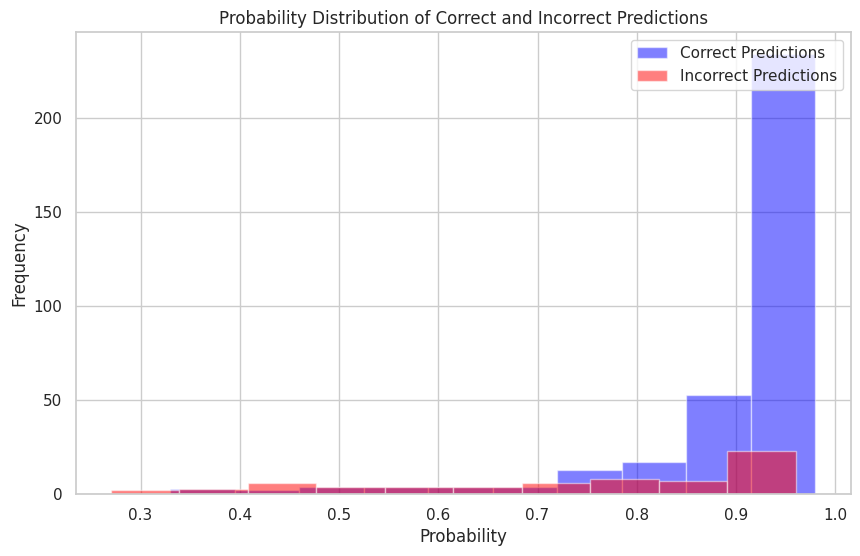

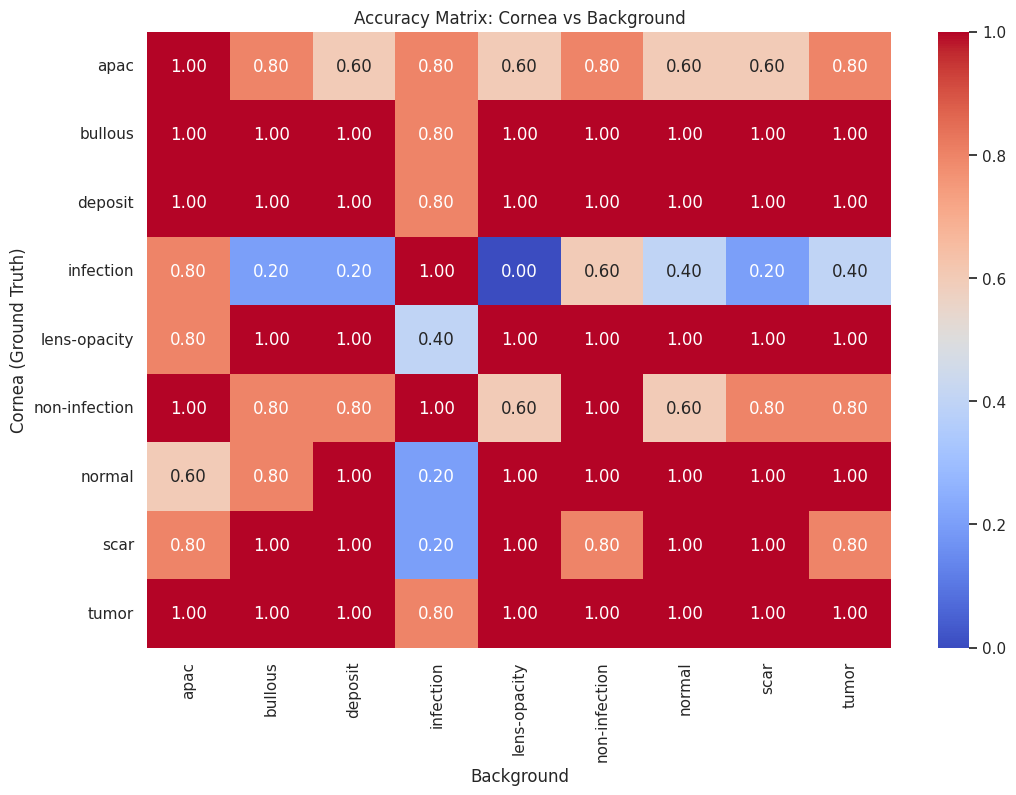

Overall accuracy: 0.83

Accuracy by cornea type:
cornea
apac             0.733333
bullous          0.977778
deposit          0.977778
infection        0.422222
lens-opacity     0.911111
non-infection    0.822222
normal           0.844444
scar             0.844444
tumor            0.977778
dtype: float64


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# CSVファイルの読み込み
file_path = '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_CutMix/CutMix_images/merged_results.csv'
df = pd.read_csv(file_path)

# 正しい判定の割合
correct_predictions = df[df['cornea'] == df['pred_cutmix']]
accuracy = len(correct_predictions) / len(df)

# 各状態に対する正しい判定の割合
correct_by_cornea = df[df['cornea'] == df['pred_cutmix']].groupby('cornea').size() / df.groupby('cornea').size()

# 確率の分布
correct_probs = correct_predictions['prob_cutmix']
incorrect_probs = df[df['cornea'] != df['pred_cutmix']]['prob_cutmix']

# ヒストグラムをプロット
plt.figure(figsize=(10, 6))
plt.hist(correct_probs, bins=10, alpha=0.5, label='Correct Predictions', color='blue')
plt.hist(incorrect_probs, bins=10, alpha=0.5, label='Incorrect Predictions', color='red')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title('Probability Distribution of Correct and Incorrect Predictions')
plt.show()

# グラウンドトゥルースごとの背景に対する正解率マトリックスを作成
matrix = df.pivot_table(index='cornea', columns='background', values='pred_cutmix', aggfunc=lambda x: (x == df.loc[x.index, 'cornea']).mean())

# マトリックス図をプロット
plt.figure(figsize=(12, 8))
sns.heatmap(matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title('Accuracy Matrix: Cornea vs Background')
plt.xlabel('Background')
plt.ylabel('Cornea (Ground Truth)')
plt.show()

# 結果の出力
print(f"Overall accuracy: {accuracy:.2f}")
print("\nAccuracy by cornea type:")
print(correct_by_cornea)

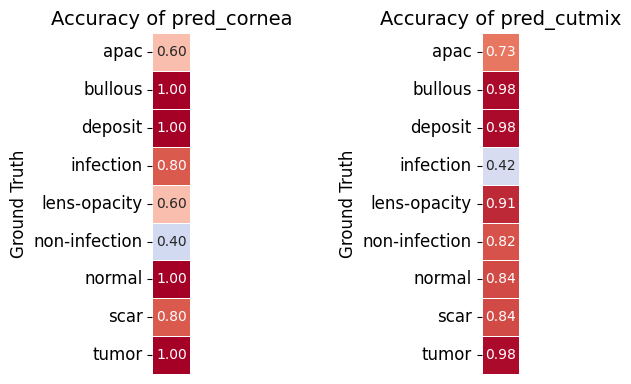

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# CSVファイルの読み込み
file_path = '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_CutMix/CutMix_images/merged_results.csv'
df = pd.read_csv(file_path)

# pred_corneaとpred_cutmixの正解率を計算
correct_pred_cornea = df['cornea'] == df['pred_cornea']
accuracy_pred_cornea = correct_pred_cornea.groupby(df['cornea']).mean()

correct_pred_cutmix = df['cornea'] == df['pred_cutmix']
accuracy_pred_cutmix = correct_pred_cutmix.groupby(df['cornea']).mean()

# カスタムカラーマップの作成
colors = ['#3b4cc0', '#6788ee', '#9abbff', '#c9d7f0', '#ede4ef', '#fbb7a1', '#e6705b', '#cc4040', '#a50026']
n_bins = 100
cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)

# グローバルフォントサイズの設定
plt.rcParams.update({'font.size': 12})

# プロットの作成（サイズを16x8に変更）
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# pred_corneaのヒートマップ
sns.heatmap(accuracy_pred_cornea.to_frame(), annot=True, fmt=".2f",
            cmap=cmap, cbar=False, vmin=0, vmax=1, linewidths=0.5, square=True, ax=ax1,
            annot_kws={'size': 10})
ax1.set_title('Accuracy of pred_cornea', fontsize=14)
ax1.set_xlabel('')
ax1.set_ylabel('Ground Truth', fontsize=12)
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax1.set_aspect('equal')

# pred_cutmixのヒートマップ
sns.heatmap(accuracy_pred_cutmix.to_frame(), annot=True, fmt=".2f",
            cmap=cmap, cbar=False, vmin=0, vmax=1, linewidths=0.5, square=True, ax=ax2,
            annot_kws={'size': 10})
ax2.set_title('Accuracy of pred_cutmix', fontsize=14)
ax2.set_xlabel('')
ax2.set_ylabel('Ground Truth', fontsize=12)
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax2.set_aspect('equal')

plt.tight_layout()
plt.show()


In [13]:
import pandas as pd
import numpy as np
from statsmodels.stats.contingency_tables import mcnemar

# CSVファイルの読み込み
file_path = '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_CutMix/CutMix_images/merged_results.csv'
df = pd.read_csv(file_path)

def perform_mcnemar_test(df, cornea_type):
    # 特定の角膜タイプのデータを抽出
    cornea_data = df[df['cornea'] == cornea_type]

    # pred_corneaとpred_cutmixの正誤を比較
    table = pd.crosstab(cornea_data['pred_cornea'] == cornea_type,
                        cornea_data['pred_cutmix'] == cornea_type)

    # McNemar's testの実行
    if table.shape == (2, 2):
        result = mcnemar(table, exact=False, correction=True)
        return result.pvalue
    else:
        return None  # 変化がない場合

# 結果を格納するリスト
results_list = []

# 各角膜タイプに対してテストを実行
for cornea_type in df['cornea'].unique():
    p_value = perform_mcnemar_test(df, cornea_type)

    # 正解率の計算
    cornea_data = df[df['cornea'] == cornea_type]
    accuracy_pred_cornea = (cornea_data['pred_cornea'] == cornea_type).mean()
    accuracy_pred_cutmix = (cornea_data['pred_cutmix'] == cornea_type).mean()

    results_list.append({
        'Cornea Type': cornea_type,
        'P-value': p_value,
        'Accuracy (pred_cornea)': accuracy_pred_cornea,
        'Accuracy (pred_cutmix)': accuracy_pred_cutmix,
        'Accuracy Change': accuracy_pred_cutmix - accuracy_pred_cornea
    })

# リストをデータフレームに変換
results = pd.DataFrame(results_list)

# 有意水準を設定（例: 0.05）
alpha = 0.05

# 有意差の判定と解釈
results['Significant'] = results['P-value'].apply(lambda x: x < alpha if x is not None else None)
results['Interpretation'] = results.apply(lambda row:
    "Significant change" if row['Significant'] == True else
    "No significant change" if row['Significant'] == False else
    "No change observed", axis=1)

# 結果の表示
pd.set_option('display.float_format', '{:.4f}'.format)
print(results)

# 全体の正解率の変化
overall_accuracy_pred_cornea = (df['pred_cornea'] == df['cornea']).mean()
overall_accuracy_pred_cutmix = (df['pred_cutmix'] == df['cornea']).mean()

print(f"\nOverall Accuracy (pred_cornea): {overall_accuracy_pred_cornea:.4f}")
print(f"Overall Accuracy (pred_cutmix): {overall_accuracy_pred_cutmix:.4f}")
print(f"Overall Accuracy Change: {overall_accuracy_pred_cutmix - overall_accuracy_pred_cornea:.4f}")

     Cornea Type  P-value  Accuracy (pred_cornea)  Accuracy (pred_cutmix)  \
0           apac   0.1814                  0.6000                  0.7333   
1        bullous      NaN                  1.0000                  0.9778   
2        deposit      NaN                  1.0000                  0.9778   
3      infection   0.0005                  0.8000                  0.4222   
4   lens-opacity   0.0012                  0.6000                  0.9111   
5  non-infection   0.0001                  0.4000                  0.8222   
6         normal      NaN                  1.0000                  0.8444   
7           scar   0.7237                  0.8000                  0.8444   
8          tumor      NaN                  1.0000                  0.9778   

   Accuracy Change  Significant         Interpretation  
0           0.1333        False  No significant change  
1          -0.0222        False  No significant change  
2          -0.0222        False  No significant change  
3

In [16]:
import pandas as pd
import numpy as np
from scipy import stats

# CSVファイルの読み込み
file_path = '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_CutMix/CutMix_images/merged_results.csv'
df = pd.read_csv(file_path)

def perform_binomial_test(successes, trials, expected_prob):
    return stats.binomtest(successes, trials, expected_prob, alternative='less').pvalue

def compare_accuracy(df, prediction_col):
    results = []
    classes = df['cornea'].unique()

    # 全体の正解率を計算
    overall_accuracy = (df[prediction_col] == df['cornea']).mean()

    for cls in classes:
        class_data = df[df['cornea'] == cls]
        correct = (class_data[prediction_col] == class_data['cornea']).sum()
        total = len(class_data)
        accuracy = correct / total

        # 二項検定を実行
        p_value = perform_binomial_test(correct, total, overall_accuracy)

        results.append({
            'Class': cls,
            'Accuracy': accuracy,
            'P-value': p_value,
            'Significant': p_value < 0.05
        })

    return pd.DataFrame(results)

# 説明文の追加
explanation = """
分析手法の説明:
1. 使用した統計手法: 二項検定（Binomial test）

2. 二項検定を選択した理由:
   a) 各予測は成功（正解）または失敗（不正解）の二値データである。
   b) 各クラスの予測を、全体の正解率と比較できる。
   c) サンプルサイズが小さい場合でも適用可能である。

3. 検定の実施方法:
   - 帰無仮説: クラスの正解率は全体の正解率と同じか、それより高い。
   - 対立仮説: クラスの正解率は全体の正解率より低い。
   - 有意水準: 0.05 (5%)

4. 結果の解釈:
   - P値が0.05未満の場合、そのクラスの正解率は全体の正解率よりも有意に低いと判断する。
   - 'Significant' 列がTrueの場合、そのクラスは他のクラスよりも有意に低い正解率を示している。

注意点:
- この分析は各予測方法（CorneavsKutMix）内での比較であり、Cornea予測とCutMix予測の直接比較ではない。
- 多重比較の問題が生じる可能性があるため、結果の解釈には注意が必要である。
- 必要に応じて、Bonferroni補正などの多重比較補正を検討することが推奨される。
"""

print(explanation)

# Cornea予測の比較
print("\nComparison within Cornea predictions:")
cornea_results = compare_accuracy(df, 'pred_cornea')
print(cornea_results)

print("\nComparison within CutMix predictions:")
cutmix_results = compare_accuracy(df, 'pred_cutmix')
print(cutmix_results)

# 全体の正解率を表示
print(f"\nOverall Accuracy (Cornea): {(df['pred_cornea'] == df['cornea']).mean():.4f}")
print(f"Overall Accuracy (CutMix): {(df['pred_cutmix'] == df['cornea']).mean():.4f}")

# 結果の解釈
print("\n結果の解釈:")
print("1. P値が0.05未満（'Significant'がTrue）のクラスは、その予測方法内で他のクラスよりも有意に低い正解率を示しています。")
print("2. これらのクラスは、予測モデルが特に苦手としている可能性があり、改善の余地があることを示唆しています。")
print("3. 有意差がないクラスは、全体の正解率と統計的に異なる性能を示していないと解釈できます。")
print("4. この分析結果を基に、特定のクラスに対する予測モデルの改善や、データ収集の見直しなどを検討することができます。")


分析手法の説明:
1. 使用した統計手法: 二項検定（Binomial test）

2. 二項検定を選択した理由:
   a) 各予測は成功（正解）または失敗（不正解）の二値データである。
   b) 各クラスの予測を、全体の正解率と比較できる。
   c) サンプルサイズが小さい場合でも適用可能である。

3. 検定の実施方法:
   - 帰無仮説: クラスの正解率は全体の正解率と同じか、それより高い。
   - 対立仮説: クラスの正解率は全体の正解率より低い。
   - 有意水準: 0.05 (5%)

4. 結果の解釈:
   - P値が0.05未満の場合、そのクラスの正解率は全体の正解率よりも有意に低いと判断する。
   - 'Significant' 列がTrueの場合、そのクラスは他のクラスよりも有意に低い正解率を示している。

注意点:
- この分析は各予測方法（CorneavsKutMix）内での比較であり、Cornea予測とCutMix予測の直接比較ではない。
- 多重比較の問題が生じる可能性があるため、結果の解釈には注意が必要である。
- 必要に応じて、Bonferroni補正などの多重比較補正を検討することが推奨される。


Comparison within Cornea predictions:
           Class  Accuracy  P-value  Significant
0           apac    0.6000   0.0017         True
1        bullous    1.0000   1.0000        False
2        deposit    1.0000   1.0000        False
3      infection    0.8000   0.5593        False
4   lens-opacity    0.6000   0.0017         True
5  non-infection    0.4000   0.0000         True
6         normal    1.0000   1.0000        False
7           scar    0.8000   0.5593

In [ ]:
!pip install scipy

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.stats.contingency_tables import mcnemar

# 各モデルの予測が正解かどうかをブール値で表す
correct_cornea = df['cornea'] == df['pred_cornea']
correct_cutmix = df['cornea'] == df['pred_cutmix']

# McNemar検定のためのコンティンジェンシーテーブルを作成
table = pd.crosstab(correct_cornea, correct_cutmix)
data = np.array([
    [table.loc[True, True], table.loc[True, False]],
    [table.loc[False, True], table.loc[False, False]]
])

# McNemar検定の実行
result = mcnemar(data, exact=True)

print("McNemar's test results:")
print(f'p-value: {result.pvalue}')
print(f'statistic: {result.statistic}')

# 各カテゴリごとの正答率の変化を計算
print("\nAccuracy changes by category:")
categories = df['cornea'].unique()
for category in categories:
    cat_data = df[df['cornea'] == category]
    cornea_acc = np.mean(cat_data['cornea'] == cat_data['pred_cornea'])
    cutmix_acc = np.mean(cat_data['cornea'] == cat_data['pred_cutmix'])
    diff = cutmix_acc - cornea_acc
    print(f"{category}: Cornea acc: {cornea_acc:.3f}, CutMix acc: {cutmix_acc:.3f}, Difference: {diff:.3f}")

# 全体の正答率の変化
total_cornea_acc = np.mean(correct_cornea)
total_cutmix_acc = np.mean(correct_cutmix)
total_diff = total_cutmix_acc - total_cornea_acc
print(f"\nOverall: Cornea acc: {total_cornea_acc:.3f}, CutMix acc: {total_cutmix_acc:.3f}, Difference: {total_diff:.3f}")

McNemar's test results:
p-value: 0.14179337454474714
statistic: 38.0

Accuracy changes by category:
apac: Cornea acc: 0.600, CutMix acc: 0.733, Difference: 0.133
bullous: Cornea acc: 1.000, CutMix acc: 0.978, Difference: -0.022
deposit: Cornea acc: 1.000, CutMix acc: 0.978, Difference: -0.022
infection: Cornea acc: 0.800, CutMix acc: 0.422, Difference: -0.378
lens-opacity: Cornea acc: 0.600, CutMix acc: 0.911, Difference: 0.311
non-infection: Cornea acc: 0.400, CutMix acc: 0.822, Difference: 0.422
normal: Cornea acc: 0.978, CutMix acc: 0.844, Difference: -0.133
scar: Cornea acc: 0.800, CutMix acc: 0.844, Difference: 0.044
tumor: Cornea acc: 1.000, CutMix acc: 0.978, Difference: -0.022

Overall: Cornea acc: 0.798, CutMix acc: 0.835, Difference: 0.037


#**Inference cornea vs original images**

In [ ]:
import pandas as pd
import os
import cv2
import torch

def process_image(img_path, model):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    torch_img = model.preprocessing(img)
    with torch.no_grad():
        prediction, logits = model(torch_img)
    if len(prediction[2][0]) > 0:
        top_class = prediction[2][0][0]
        top_prob = prediction[3][0][0]
        return top_class, top_prob
    else:
        return "No detection", 0.0

def process_folders(folder_path_cornea, folder_path_original, model):
    results = []
    for cornea_img_name in os.listdir(folder_path_cornea):
        if cornea_img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
            cornea_img_path = os.path.join(folder_path_cornea, cornea_img_name)

            # Construct the corresponding original image name (always .jpg)
            original_img_name = os.path.splitext(cornea_img_name)[0] + '.jpg'
            original_img_path = os.path.join(folder_path_original, original_img_name)

            if not os.path.exists(original_img_path):
                print(f"Warning: Corresponding original image not found for {cornea_img_name}")
                continue

            # Process cornea image
            cornea_top_class, cornea_top_prob = process_image(cornea_img_path, model)

            # Process original image
            original_top_class, original_top_prob = process_image(original_img_path, model)

            # Split filename to get groundtruth
            parts = cornea_img_name.split('_')
            groundtruth = parts[0] if len(parts) >= 2 else "Unknown"

            results.append({
                "basename": cornea_img_name,
                "image_id": f"{parts[0]}_{parts[1].split('.')[0]}",
                "groundtruth": groundtruth,
                "pred_original": original_top_class,
                "prob_original": original_top_prob,
                "pred_cornea": cornea_top_class,
                "prob_cornea": cornea_top_prob
            })

            print(f"Processing image: {cornea_img_name}")
            print(f"  Original - Top class: {original_top_class}, Probability: {original_top_prob:.4f}")
            print(f"  Cornea   - Top class: {cornea_top_class}, Probability: {cornea_top_prob:.4f}")

    return pd.DataFrame(results)

if __name__ == '__main__':
    model_path = "/content/drive/MyDrive/Deep_learning/CorneAI_nagoya/yolo5_forcresco/weights/eye_nii_2202_onecaseoneimage2_doctorcompare_yolov5s_epoch200_batch16_89.8p/last.pt"
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    img_size = (640, 640)

    folder_path_cornea = '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_CutMix/CutMix_images/cornea'
    folder_path_original = '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_CutMix/CutMix_images/original'

    print(f"Using device: {device}")
    print(f"Processing cornea folder: {folder_path_cornea}")
    print(f"Processing original folder: {folder_path_original}")

    # Updated class names
    classes = ["infection", "normal", "non-infection", "scar", "tumor", "deposit", "apac", "lens-opacity", "bullous"]

    model = YOLOV5TorchObjectDetector(model_path, device, img_size=img_size, names=classes)

    df = process_folders(folder_path_cornea, folder_path_original, model)

    print("\nDataFrame:")
    print(df)

    csv_path = '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_CutMix/CutMix_images/comparison_results.csv'
    df.to_csv(csv_path, index=False)
    print(f"\nCSV saved to: {csv_path}")


In [ ]:
import pandas as pd
import os

def read_csv_safe(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"ファイルが見つかりません: {file_path}")
    return pd.read_csv(file_path)

try:
    # CSVファイルのパスを指定
    cutmix_path = '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_CutMix/CutMix_images/cutmix.csv'
    comparison_path = '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_CutMix/CutMix_images/comparison_results.csv'

    # 2つのCSVファイルを読み込む
    cutmix_df = read_csv_safe(cutmix_path)
    comparison_df = read_csv_safe(comparison_path)

    # 列名を表示して確認
    print("cutmix.csv の列名:", cutmix_df.columns)
    print("comparison_results.csv の列名:", comparison_df.columns)

    # cutmix_dfに新しい列を追加
    new_columns = ["pred_original", "prob_original", "pred_cornea", "prob_cornea"]
    for col in new_columns:
        cutmix_df[col] = None

    # comparison_dfのimage_id列を修正（.pngを除去）
    comparison_df['image_id'] = comparison_df['image_id'].str.replace('.png', '')

    # cutmix_dfの各行に対して、comparison_dfから対応するデータを取得
    for index, row in cutmix_df.iterrows():
        matching_row = comparison_df[comparison_df['image_id'] == row['image_id']]
        if not matching_row.empty:
            for col in new_columns:
                cutmix_df.at[index, col] = matching_row[col].values[0]

    # 結果をCSVファイルに出力
    output_path = '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_CutMix/CutMix_images/merged_results.csv'
    cutmix_df.to_csv(output_path, index=False)

    print(f"CSVファイルの結合が完了しました。結果は '{output_path}' に保存されています。")

    # 結果の最初の数行を表示
    print("\n結合されたデータの最初の数行:")
    print(cutmix_df.head())

    # 新しく追加された列の欠損値の数を表示し、欠損のある画像のbasenameを表示
    print("\n新しく追加された列の欠損値の数と対応する画像のbasename:")
    for col in new_columns:
        null_count = cutmix_df[col].isnull().sum()
        print(f"{col}: {null_count}")
        if null_count > 0:
            print(f"  欠損のある画像のbasename:")
            null_images = cutmix_df[cutmix_df[col].isnull()]['basename'].tolist()
            for img in null_images:
                print(f"    {img}")


except FileNotFoundError as e:
    print(f"エラー: {e}")
    print("Google Driveがマウントされていることを確認してください。")
except Exception as e:
    print(f"予期せぬエラーが発生しました: {e}")

#**Analyze results**

In [ ]:
import pandas as pd
from scipy.stats import ttest_rel

def analyze_comparison_results(csv_path):
    # CSVファイルの読み込み
    data = pd.read_csv(csv_path)

    # 確率の差を計算
    data['prob_difference'] = data['prob_original'] - data['prob_cornea']
    data['cornea_correct'] = data['groundtruth'] == data['pred_cornea']

    # クラスごとの平均確率と差、正解率を計算
    class_prob_means = data.groupby('groundtruth')[['prob_original', 'prob_cornea']].mean().reset_index()
    class_prob_means['prob_difference'] = class_prob_means['prob_original'] - class_prob_means['prob_cornea']
    class_correct_rates = data.groupby('groundtruth')['cornea_correct'].mean().reset_index()

    # 対応のあるt検定を実施
    significance_results = data['groundtruth'].unique()
    paired_significance_results = []

    for class_name in significance_results:
        class_data = data[data['groundtruth'] == class_name]
        t_stat, p_value = ttest_rel(class_data['prob_original'], class_data['prob_cornea'])
        paired_significance_results.append((class_name, t_stat, p_value))

    # 結果をDataFrameにまとめる
    paired_significance_df = pd.DataFrame(paired_significance_results, columns=['Class', 't_stat', 'p_value'])
    class_prob_means = class_prob_means.merge(paired_significance_df, left_on='groundtruth', right_on='Class').drop('Class', axis=1)
    class_prob_means = class_prob_means.merge(class_correct_rates, on='groundtruth').rename(columns={'cornea_correct': 'cornea_accuracy'})

    # 全体の正解率を計算
    overall_accuracy = data['cornea_correct'].mean()

    return class_prob_means, overall_accuracy

# CSVファイルのパス
csv_path = '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_CutMix/CutMix_images/comparison_results.csv'

# 分析結果を取得
result_df, overall_accuracy = analyze_comparison_results(csv_path)

# 結果を表示
print("Class-specific results:")
print(result_df)
print("\nOverall accuracy:", overall_accuracy)

Class-specific results:
     groundtruth  prob_original  prob_cornea  prob_difference    t_stat   p_value  cornea_accuracy
0           apac          0.944        0.618            0.326  3.867274  0.018035              0.6
1        bullous          0.928        0.800            0.128  4.967363  0.007666              1.0
2        deposit          0.968        0.888            0.080  3.090670  0.036551              1.0
3      infection          0.958        0.648            0.310  3.216280  0.032395              0.8
4   lens-opacity          0.866        0.642            0.224  2.713209  0.053360              0.6
5  non-infection          0.872        0.650            0.222  1.973509  0.119688              0.4
6         normal          0.970        0.754            0.216  5.291956  0.006120              1.0
7           scar          0.916        0.736            0.180  2.821469  0.047757              0.8
8          tumor          0.864        0.884           -0.020 -0.395285  0.712807    

In [ ]:
import pandas as pd
from scipy.stats import ttest_rel

# Set display options
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

def analyze_comparison_results(csv_path):
    # Read the CSV file
    data = pd.read_csv(csv_path)

    # Calculate probability differences
    data['prob_difference_original_cornea'] = data['prob_original'] - data['prob_cornea']
    data['prob_difference_original_cutmix'] = data['prob_original'] - data['prob_cutmix']

    # Calculate correctness for each model
    data['cornea_correct'] = data['groundtruth'] == data['pred_cornea']
    data['cutmix_correct'] = data['groundtruth'] == data['pred_cutmix']
    data['original_correct'] = data['groundtruth'] == data['pred_original']

    # Calculate class-specific mean probabilities, differences, and accuracies
    class_metrics = data.groupby('groundtruth').agg({
        'prob_original': 'mean',
        'prob_cornea': 'mean',
        'prob_cutmix': 'mean',
        'prob_difference_original_cornea': 'mean',
        'prob_difference_original_cutmix': 'mean',
        'cornea_correct': 'mean',
        'cutmix_correct': 'mean',
        'original_correct': 'mean'
    }).reset_index()

    # Rename columns for clarity
    class_metrics = class_metrics.rename(columns={
        'cornea_correct': 'cornea_accuracy',
        'cutmix_correct': 'cutmix_accuracy',
        'original_correct': 'original_accuracy'
    })

    # Perform paired t-tests
    significance_results = []
    for class_name in data['groundtruth'].unique():
        class_data = data[data['groundtruth'] == class_name]

        # Original vs Cornea
        t_stat_oc, p_value_oc = ttest_rel(class_data['prob_original'], class_data['prob_cornea'])

        # Original vs CutMix
        t_stat_om, p_value_om = ttest_rel(class_data['prob_original'], class_data['prob_cutmix'])

        significance_results.append((class_name, t_stat_oc, p_value_oc, t_stat_om, p_value_om))

    # Create DataFrame for significance results
    significance_df = pd.DataFrame(significance_results,
                                   columns=['Class', 't_stat_orig_cornea', 'p_value_orig_cornea',
                                            't_stat_orig_cutmix', 'p_value_orig_cutmix'])

    # Merge significance results with class metrics
    result_df = class_metrics.merge(significance_df, left_on='groundtruth', right_on='Class').drop('Class', axis=1)

    # Calculate overall accuracies
    overall_accuracies = {
        'cornea': data['cornea_correct'].mean(),
        'cutmix': data['cutmix_correct'].mean(),
        'original': data['original_correct'].mean()
    }

    return result_df, overall_accuracies

# CSV file path
csv_path = '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_CutMix/CutMix_images/merged_results.csv'

# Get analysis results
result_df, overall_accuracies = analyze_comparison_results(csv_path)

# Display results
print("Class-specific results:")
print(result_df)
print("\nOverall accuracies:")
for model, accuracy in overall_accuracies.items():
    print(f"{model.capitalize()} model accuracy: {accuracy:.4f}")

result_df

Class-specific results:
     groundtruth  prob_original  prob_cornea  prob_cutmix  prob_difference_original_cornea  prob_difference_original_cutmix  cornea_accuracy  cutmix_accuracy  original_accuracy  t_stat_orig_cornea  p_value_orig_cornea  t_stat_orig_cutmix  p_value_orig_cutmix
0           apac          0.944        0.618     0.877111                            0.326                         0.066889              0.6         0.733333                1.0           12.826298         1.826874e-16            3.010636         4.306381e-03
1        bullous          0.928        0.800     0.910444                            0.128                         0.017556              1.0         0.977778                1.0           16.474880         1.946242e-20            1.051394         2.988181e-01
2        deposit          0.968        0.888     0.962222                            0.080                         0.005778              1.0         0.977778                1.0           10.250592   

,groundtruth,prob_original,prob_cornea,prob_cutmix,prob_difference_original_cornea,prob_difference_original_cutmix,cornea_accuracy,cutmix_accuracy,original_accuracy,t_stat_orig_cornea,p_value_orig_cornea,t_stat_orig_cutmix,p_value_orig_cutmix
0,apac,0.944,0.618,0.877111,0.326,0.066889,0.6,0.733333,1.0,12.826298,1.826874e-16,3.010636,4.306381e-03
1,bullous,0.928,0.800,0.910444,0.128,0.017556,1.0,0.977778,1.0,16.474880,1.946242e-20,1.051394,2.988181e-01
2,deposit,0.968,0.888,0.962222,0.080,0.005778,1.0,0.977778,1.0,10.250592,3.096740e-13,1.656170,1.048030e-01
3,infection,0.958,0.648,0.766444,0.310,0.191556,0.8,0.422222,1.0,10.667194,8.778571e-14,6.618870,4.147171e-08
4,lens-opacity,0.866,0.642,0.799556,0.224,0.066444,0.6,0.911111,1.0,8.998696,1.558550e-11,2.646541,1.123944e-02
5,non-infection,0.872,0.650,0.854000,0.222,0.018000,0.4,0.822222,1.0,6.545388,5.319120e-08,0.865035,3.917116e-01
6,normal,0.970,0.754,0.906889,0.216,0.063111,1.0,0.844444,1.0,17.551434,1.721812e-21,3.998918,2.397927e-04
7,scar,0.916,0.736,0.866667,0.180,0.049333,0.8,0.844444,1.0,9.357754,4.968290e-12,2.927499,5.391751e-03
8,tumor,0.864,0.884,0.924444,-0.020,-0.060444,1.0,0.977778,1.0,-1.311011,1.966552e-01,-3.029900,4.085955e-03


In [ ]:
import pandas as pd
import statsmodels.api as sm

# CSVファイルのパス
csv_path = '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_CutMix/CutMix_images/merged_results.csv'

# CSVファイルを読み込む
data = pd.read_csv(csv_path)

# CutMixの予測が正解かどうかを示す新しい列を作成
data['cutmix_correct'] = data['groundtruth'] == data['pred_cutmix']
#data['cutmix_correct'] = data['cornea'] == data['pred_cutmix']


# ロジスティック回帰のためのデータを準備
X = data['prob_cornea']
y = data['cutmix_correct']
X = sm.add_constant(X)

# ロジスティック回帰モデルを適用
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# ロジスティック回帰の結果を表示
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.392653
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:         cutmix_correct   No. Observations:                  405
Model:                          Logit   Df Residuals:                      403
Method:                           MLE   Df Model:                            1
Date:                Sat, 20 Jul 2024   Pseudo R-squ.:                  0.1247
Time:                        18:07:03   Log-Likelihood:                -159.02
converged:                       True   LL-Null:                       -181.67
Covariance Type:            nonrobust   LLR p-value:                 1.697e-11
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.7611      0.507     -3.475      0.001      -2.754      -0.768
prob_cornea     4.8891    

In [19]:
import pandas as pd
import statsmodels.api as sm

# CSVファイルのパス
csv_path = '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_CutMix/CutMix_images/merged_results.csv'

# CSVファイルを読み込む
data = pd.read_csv(csv_path)

# CutMixの予測が正解かどうかを示す新しい列を作成
data['cutmix_correct'] = data['groundtruth'] == data['pred_cutmix']

# ロジスティック回帰のためのデータを準備
X = data[['prob_cornea', 'prob_cutmix', 'prob_original']]
y = data['cutmix_correct']
X = sm.add_constant(X)

# ロジスティック回帰モデルを適用
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# ロジスティック回帰の結果を表示
print(result.summary())

# 各変数の単変量解析
for var in ['prob_cornea', 'prob_cutmix', 'prob_original']:
    X_single = sm.add_constant(data[var])
    model_single = sm.Logit(y, X_single).fit()
    print(f"\nSingle variable analysis for {var}:")
    print(model_single.summary().tables[1])

Optimization terminated successfully.
         Current function value: 0.338362
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:         cutmix_correct   No. Observations:                  405
Model:                          Logit   Df Residuals:                      401
Method:                           MLE   Df Model:                            3
Date:                Mon, 22 Jul 2024   Pseudo R-squ.:                  0.2457
Time:                        06:18:08   Log-Likelihood:                -137.04
converged:                       True   LL-Null:                       -181.67
Covariance Type:            nonrobust   LLR p-value:                 3.146e-19
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             4.4223      3.167      1.396      0.163      -1.785      10.629
prob_cornea       4.

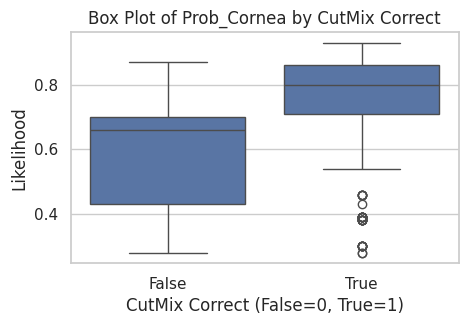

                count      mean       std   min   25%   50%   75%   max
cutmix_correct                                                         
False            67.0  0.600149  0.174447  0.28  0.43  0.66  0.70  0.87
True            338.0  0.762396  0.153771  0.28  0.71  0.80  0.86  0.93


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# CSVファイルのパス
csv_path = '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_CutMix/CutMix_images/merged_results.csv'

# CSVファイルを読み込む
data = pd.read_csv(csv_path)

# CutMixの予測が正解かどうかを示す新しい列を作成
data['cutmix_correct'] = data['cornea'] == data['pred_cutmix']

# Seabornのスタイルを設定
sns.set(style="whitegrid")

# 箱ひげ図を描く
plt.figure(figsize=(5, 3))
sns.boxplot(x='cutmix_correct', y='prob_cornea', data=data)
plt.xlabel('CutMix Correct (False=0, True=1)')
plt.ylabel('Likelihood')
plt.title('Box Plot of Prob_Cornea by CutMix Correct')
plt.show()

# 各群の統計量を表示
cutmix_correct_stats = data.groupby('cutmix_correct')['prob_cornea'].describe()
print(cutmix_correct_stats)

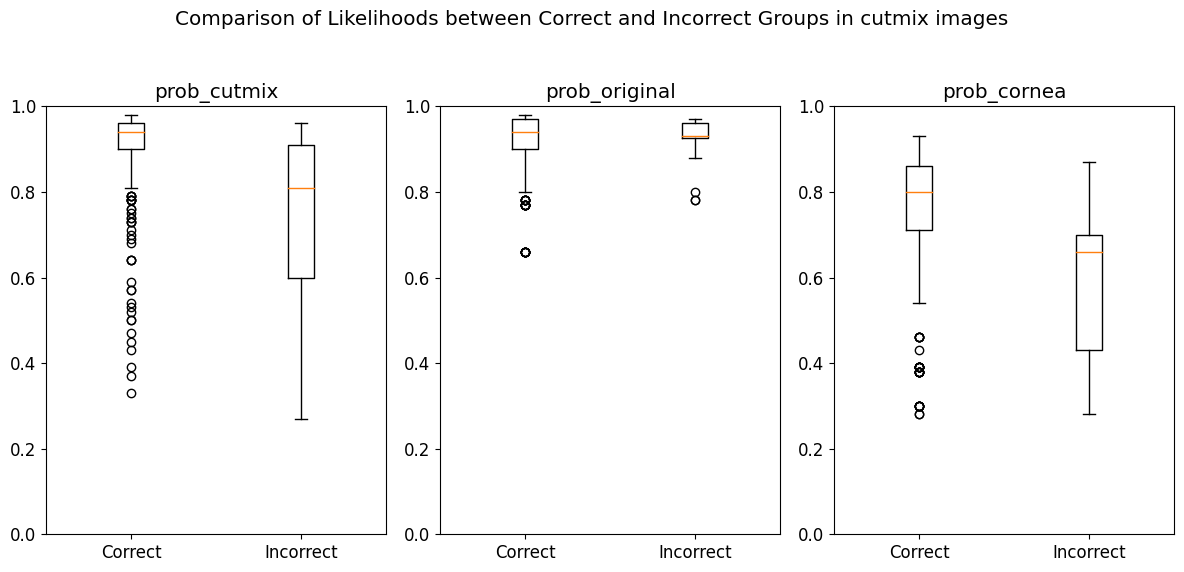

Overall Accuracy: 0.8346

Overall Means and Standard Deviations:
Overall Means:
prob_cutmix     0.8742
prob_original   0.9207
prob_cornea     0.7356
dtype: float64

Overall Standard Deviations:
prob_cutmix     0.1412
prob_original   0.0640
prob_cornea     0.1683
dtype: float64


Means and Standard Deviations by Group:
Correct Group Means:
prob_cutmix     0.9007
prob_original   0.9183
prob_cornea     0.7624
dtype: float64

Correct Group Standard Deviations:
prob_cutmix     0.1085
prob_original   0.0675
prob_cornea     0.1538
dtype: float64

Incorrect Group Means:
prob_cutmix     0.7406
prob_original   0.9325
prob_cornea     0.6001
dtype: float64

Incorrect Group Standard Deviations:
prob_cutmix     0.2004
prob_original   0.0404
prob_cornea     0.1744
dtype: float64

Mann-Whitney U Test Results:
prob_cutmix: U-statistic=18023.0, p-value=1.594493091611938e-14
prob_original: U-statistic=11102.5, p-value=0.8000770037037028
prob_cornea: U-statistic=18095.5, p-value=9.455133317353965e-15


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
%matplotlib inline

# Load the CSV file
csv_path = '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_CutMix/CutMix_images/merged_results.csv'
data = pd.read_csv(csv_path)

# Calculate overall accuracy
overall_accuracy = (data['groundtruth'] == data['pred_cutmix']).mean()

# Separate the data into correct and incorrect groups based on groundtruth and pred_cutmix
correct_group = data[data['groundtruth'] == data['pred_cutmix']]
incorrect_group = data[data['groundtruth'] != data['pred_cutmix']]

# Calculate overall means and standard deviations
overall_means = data[['prob_cutmix', 'prob_original', 'prob_cornea']].mean()
overall_stds = data[['prob_cutmix', 'prob_original', 'prob_cornea']].std()

# Calculate means and standard deviations for each group
correct_means = correct_group[['prob_cutmix', 'prob_original', 'prob_cornea']].mean()
correct_stds = correct_group[['prob_cutmix', 'prob_original', 'prob_cornea']].std()
incorrect_means = incorrect_group[['prob_cutmix', 'prob_original', 'prob_cornea']].mean()
incorrect_stds = incorrect_group[['prob_cutmix', 'prob_original', 'prob_cornea']].std()

# Perform Mann-Whitney U test
mannwhitney_cutmix = mannwhitneyu(correct_group['prob_cutmix'], incorrect_group['prob_cutmix'], alternative='two-sided')
mannwhitney_original = mannwhitneyu(correct_group['prob_original'], incorrect_group['prob_original'], alternative='two-sided')
mannwhitney_cornea = mannwhitneyu(correct_group['prob_cornea'], incorrect_group['prob_cornea'], alternative='two-sided')

# Create box plots for visual comparison
plt.figure(figsize=(12, 6))

# prob_cutmix
plt.subplot(1, 3, 1)
plt.boxplot([correct_group['prob_cutmix'], incorrect_group['prob_cutmix']], labels=['Correct', 'Incorrect'])
plt.title('prob_cutmix')
plt.ylim(0, 1)

# prob_original
plt.subplot(1, 3, 2)
plt.boxplot([correct_group['prob_original'], incorrect_group['prob_original']], labels=['Correct', 'Incorrect'])
plt.title('prob_original')
plt.ylim(0, 1)

# prob_cornea
plt.subplot(1, 3, 3)
plt.boxplot([correct_group['prob_cornea'], incorrect_group['prob_cornea']], labels=['Correct', 'Incorrect'])
plt.title('prob_cornea')
plt.ylim(0, 1)

plt.suptitle('Comparison of Likelihoods between Correct and Incorrect Groups in cutmix images')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Display results
print(f"Overall Accuracy: {overall_accuracy:.4f}")
print("\nOverall Means and Standard Deviations:")
print(f"Overall Means:\n{overall_means}\n")
print(f"Overall Standard Deviations:\n{overall_stds}\n")
print("\nMeans and Standard Deviations by Group:")
print(f"Correct Group Means:\n{correct_means}\n")
print(f"Correct Group Standard Deviations:\n{correct_stds}\n")
print(f"Incorrect Group Means:\n{incorrect_means}\n")
print(f"Incorrect Group Standard Deviations:\n{incorrect_stds}\n")

print("Mann-Whitney U Test Results:")
print(f"prob_cutmix: U-statistic={mannwhitney_cutmix.statistic}, p-value={mannwhitney_cutmix.pvalue}")
print(f"prob_original: U-statistic={mannwhitney_original.statistic}, p-value={mannwhitney_original.pvalue}")
print(f"prob_cornea: U-statistic={mannwhitney_cornea.statistic}, p-value={mannwhitney_cornea.pvalue}")

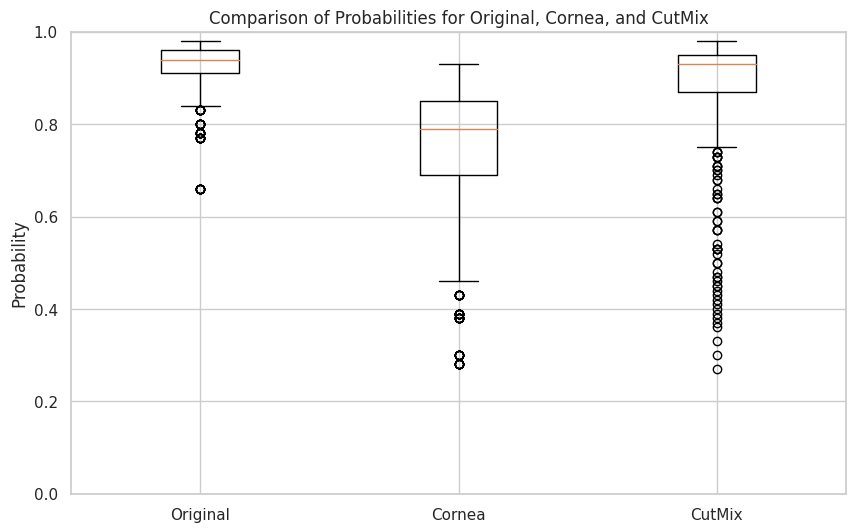

Descriptive Statistics:
       prob_original  prob_cornea  prob_cutmix
count     405.000000   405.000000   405.000000
mean        0.920667     0.735556     0.874198
std         0.064003     0.168342     0.141171
min         0.660000     0.280000     0.270000
25%         0.910000     0.690000     0.870000
50%         0.940000     0.790000     0.930000
75%         0.960000     0.850000     0.950000
max         0.980000     0.930000     0.980000

Friedman Test Results:
Statistic: 411.7012
p-value: 0.0000

Post-hoc Wilcoxon signed-rank tests (with Bonferroni correction):
Original vs Cornea: statistic=2889.0000, p-value=0.0000
Original vs CutMix: statistic=22443.0000, p-value=0.0000
Cornea vs CutMix: statistic=8435.5000, p-value=0.0000

Bonferroni corrected alpha: 0.0167


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

# Load the CSV file (assuming the path is the same as before)
csv_path = '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_CutMix/CutMix_images/merged_results.csv'
data = pd.read_csv(csv_path)

# Calculate descriptive statistics
desc_stats = data[['prob_original', 'prob_cornea', 'prob_cutmix']].describe()

# Perform Friedman test
friedman_statistic, friedman_p_value = stats.friedmanchisquare(
    data['prob_original'], data['prob_cornea'], data['prob_cutmix']
)

# Perform post-hoc Wilcoxon signed-rank tests with Bonferroni correction
wilcoxon_original_cornea = stats.wilcoxon(data['prob_original'], data['prob_cornea'])
wilcoxon_original_cutmix = stats.wilcoxon(data['prob_original'], data['prob_cutmix'])
wilcoxon_cornea_cutmix = stats.wilcoxon(data['prob_cornea'], data['prob_cutmix'])

# Bonferroni correction
alpha = 0.05
bonferroni_alpha = alpha / 3  # number of comparisons

# Create box plot
plt.figure(figsize=(10, 6))
plt.boxplot([data['prob_original'], data['prob_cornea'], data['prob_cutmix']],
            labels=['Original', 'Cornea', 'CutMix'])
plt.title('Comparison of Probabilities for Original, Cornea, and CutMix')
plt.ylabel('Probability')
plt.ylim(0, 1)
plt.show()

# Print results
print("Descriptive Statistics:")
print(desc_stats)
print("\nFriedman Test Results:")
print(f"Statistic: {friedman_statistic:.4f}")
print(f"p-value: {friedman_p_value:.4f}")

print("\nPost-hoc Wilcoxon signed-rank tests (with Bonferroni correction):")
print(f"Original vs Cornea: statistic={wilcoxon_original_cornea.statistic:.4f}, p-value={wilcoxon_original_cornea.pvalue:.4f}")
print(f"Original vs CutMix: statistic={wilcoxon_original_cutmix.statistic:.4f}, p-value={wilcoxon_original_cutmix.pvalue:.4f}")
print(f"Cornea vs CutMix: statistic={wilcoxon_cornea_cutmix.statistic:.4f}, p-value={wilcoxon_cornea_cutmix.pvalue:.4f}")
print(f"\nBonferroni corrected alpha: {bonferroni_alpha:.4f}")

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.multivariate.manova import MANOVA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# File path
csv_path = '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_CutMix/CutMix_images/merged_results.csv'

# Load the data
data = pd.read_csv(csv_path)

# Create a binary variable for correct/incorrect predictions
data['correct'] = (data['groundtruth'] == data['pred_cutmix']).astype(int)

# Separate the data into correct and incorrect predictions
correct_data = data[data['correct'] == 1]
incorrect_data = data[data['correct'] == 0]

# Mann-Whitney U Test
def mann_whitney_test(var):
    statistic, p_value = stats.mannwhitneyu(
        correct_data[var],
        incorrect_data[var],
        alternative='two-sided'
    )
    return p_value

variables = ['prob_original', 'prob_cornea', 'prob_cutmix']
results = {var: mann_whitney_test(var) for var in variables}

print("Mann-Whitney U Test Results:")
for var, p_value in results.items():
    print(f"{var}: p-value = {p_value:.4f}")

# Visualize distributions
plt.figure(figsize=(15, 5))
for i, var in enumerate(variables):
    plt.subplot(1, 3, i+1)
    sns.histplot(data=data, x=var, hue='correct', kde=True, element="step")
    plt.title(f'Distribution of {var}')
plt.tight_layout()
plt.show()

# MANOVA
X = data[variables]
y = data['correct']

manova = MANOVA.from_formula('prob_original + prob_cornea + prob_cutmix ~ correct', data=data)
print("\nMANOVA Results:")
print(manova.mv_test())

# Logistic Regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("\nLogistic Regression Results:")
print(classification_report(y_test, y_pred))

print("\nCoefficients:")
for var, coef in zip(X.columns, model.coef_[0]):
    print(f"{var}: {coef:.4f}")

# Visualize coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x=variables, y=model.coef_[0])
plt.title('Logistic Regression Coefficients')
plt.ylabel('Coefficient Value')
plt.show()

# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(data[variables + ['correct']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Box plots
plt.figure(figsize=(15, 5))
for i, var in enumerate(variables):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x='correct', y=var, data=data)
    plt.title(f'Box Plot of {var}')
plt.tight_layout()
plt.show()

In [ ]:
#prob_cutmix, prob_cornea, prob_originalの相関分析

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# CSVファイルのパスを設定
csv_path = '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_CutMix/CutMix_images/merged_results.csv'

# データの読み込み
data = pd.read_csv(csv_path)

# 相関行列の計算
corr_matrix = data[['prob_original', 'prob_cornea', 'prob_cutmix']].corr()

# ヒートマップの作成
plt.figure(figsize=(5, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap of Probability Variables')
plt.show()

# 散布図行列の作成
sns.pairplot(data[['prob_original', 'prob_cornea', 'prob_cutmix']], diag_kind='kde')
plt.suptitle('Scatter Plot Matrix of Likelihood Variables', y=1.02)
plt.show()

# 相関係数の出力
print("Correlation Matrix:")
print(corr_matrix)

In [ ]:
#クラスごと：prob_cutmix, prob_cornea, prob_originalの相関分析

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# CSVファイルのパス
csv_path = '/content/drive/MyDrive/研究/進行中の研究/角膜スマートフォンAIプロジェクト/前原の240問_CutMix/CutMix_images/merged_results.csv'

# データの読み込み
data = pd.read_csv(csv_path)

# クラスのリストを取得（ユニークな疾患カテゴリー）
classes = data['groundtruth'].unique()

# # クラスごとの相関行列を計算し、プロットする関数
# def plot_class_correlations(data, classes):
#     n_classes = len(classes)
#     fig, axes = plt.subplots(n_classes, 1, figsize=(5, 3*n_classes))
#     #fig.suptitle('Class-specific Correlation Heatmaps of Likelihood Variables', fontsize=16)

#     for i, cls in enumerate(classes):
#         class_data = data[data['groundtruth'] == cls]
#         corr_matrix = class_data[['prob_original', 'prob_cornea', 'prob_cutmix']].corr()

#         sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, ax=axes[i])
#         axes[i].set_title(f'Correlation for class: {cls}')

#     plt.tight_layout()
#     plt.show()

# # クラスごとの相関行列をプロット
# plot_class_correlations(data, classes)

# クラスごとの相関係数を計算し、結果を表示
print("Class-specific Correlation Coefficients:")
for cls in classes:
    class_data = data[data['groundtruth'] == cls]
    corr_matrix = class_data[['prob_original', 'prob_cornea', 'prob_cutmix']].corr()
    print(f"\nClass: {cls}")
    print(corr_matrix)

In [ ]:
"""
CorneAIの注目点についてのCutMix法を用いた検討

背景：
CorneAIはYOLOv5をベースとして、細隙前眼部の状態をclasses = ["infection", "normal", "non-infection", "scar", "tumor", "deposit", "apac", "lens-opacity", "bullous"]の9つに
分類するAIである。このAIは角膜のバウンディングボックスと分類を同時に出力するが、判定が角膜外の情報にどれだけ影響されるかは明らかになっていない。今回これを明らかにすることを目的とする。

方法：
{
  "infection": "感染",
  "normal": "正常",
  "non-infection": "非感染",
  "scar": "瘢痕",
  "tumor": "腫瘍",
  "deposit": "沈着",
  "apac": "緑内障発作",
  "bullous": "水疱性角膜症"
}

1. classes = ["infection", "normal", "non-infection", "scar", "tumor", "deposit", "apac", "lens-opacity", "bullous"]の9分類について、
CorneAIが正解した画像のうち眼瞼の被りが少なく角膜全体が写っているものを各5枚ずつ選択

2. それぞれの画像を角膜の部分だけ切り抜いたもの（角膜画像）をCorneAIで判定し、尤度と正解率が落ちるかどうかを尤度ごとに比較

3. 各分類より背景が典型的な画像をそれぞれ1枚ずつ選択、切り抜いた角膜画像を合成した画像を作成したもの（cutmix画像）をCorneAIで判定し、正解画像と不正解画像の特徴を探索した

結果：
メインリザルト
1. 正常画像の正解率100%に対して、角膜画像の正解率は80%、cutmix画像の正解率は83%であった

2. 角膜画像では、apac、lens-opacity, non-infectionがそれぞれ60%, 60%, 40%と正解率低い、cutmix画像ではinfectionが40%と正解率低い (binomial test, p<0.05)

3. 角膜画像がbullous, deposit, tumorの場合は背景が変わっても正答率が落ちにくい（98%）、角膜画像がnormal, scar, lens-opacityでは背景が充血（infection, non-infection, apac）していると正解率が落ちる、角膜がinfection, apac, non-infectionでは背景に充血がない（deposit, lens-opacitym normal, scar）と正解率が落ちる

サブリザルト：
1. 判定の尤度は元画像で0.92±0.06に対して角膜画像で0.74±0.17と低下し、cutmix画像にすることで0.87±0.14と再上昇した (p<0.01, student's t-test)

2. prob_cutmix、prob_corneaが高い方がcutmixは正解になりやすい傾向を認めた（p<0.001, logistic regression analysis）
"""

'\nCorneAIの注目点についてのCutMix法を用いた検討\n\n背景：\nCorneAIはYOLOv5をベースとして、細隙前眼部の状態をclasses = ["infection", "normal", "non-infection", "scar", "tumor", "deposit", "apac", "lens-opacity", "bullous"]の9つに\n分類するAIである。このAIは角膜のバウンディングボックスと分類を同時に出力するが、判定が角膜外の情報にどれだけ影響されるかは明らかになっていない。今回これを明らかにすることを目的とする。\n\n方法：\n1. classes = ["infection", "normal", "non-infection", "scar", "tumor", "deposit", "apac", "lens-opacity", "bullous"]の9分類について、\nCorneAIが正解した画像のうち眼瞼の被りが少なく角膜全体が写っているものを各5枚ずつ選択\n\n2. それぞれの画像を角膜の部分だけ切り抜いたもの（角膜画像）をCorneAIで判定し、尤度と正解率が落ちるかどうかを尤度ごとに比較\n\n3. 各分類より背景が典型的な画像をそれぞれ1枚ずつ選択、切り抜いた角膜画像を合成した画像を作成したもの（cutmix画像）をCorneAIで判定し、正解画像と不正解画像の特徴を探索した\n\n結果：\nメインリザルト\n1. 正常画像の正解率100%に対して、角膜画像の正解率は80%、cutmix画像の正解率は84%であった\n\n2.\n\n2. 判定の尤度は元画像で0.92±0.06に対して角膜画像で0.74±0.17と低下し、cutmix画像にすることで0.87±0.15と再上昇した\n\n3. それぞれの画像における尤度の相関係数は、元画像と角膜画像で0.07、元画像とcutmixで0.13、角膜画像とcutmixで0.37であった。\nこのことは、周辺の情報が尤度に及ぼす影響は画像により様々であることが示唆する\n\n4.\n'